<a href="https://colab.research.google.com/github/hamdansyaif/handson-ml2/blob/main/finalterm-ml/transaction%20/Fraud_Detection_Based_Transaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
⚙️ BLOK 1: INSTALLATION & SETUP
═══════════════════════════════════════════════════════
Run time: ~2 minutes
Description: Install required libraries
"""

# Install libraries (run once per session)
!pip install polars optuna imbalanced-learn catboost lightgbm xgboost -q

print("✅ Installation complete!")

✅ Installation complete!


In [ ]:
import sys
print(f"Python: {sys.executable}")

# Test imports
import pandas as pd
import polars as pl
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna

print("\n✅ ALL LIBRARIES LOADED!")
print(f"LightGBM: {lgb.__version__}")
print(f"XGBoost: {xgb.__version__}")

Python: c:\Users\hamda\.conda\envs\fraud_gpu\python.exe

✅ ALL LIBRARIES LOADED!
LightGBM: 4.6.0
XGBoost: 3.1.2


In [ ]:
"""
📚 BLOK 2: IMPORT LIBRARIES
═══════════════════════════════════════════════════════
Run time: ~10 seconds
Description: Import all required libraries and set configurations
"""

# Core libraries
import sys  # ← Import sys di sini dulu!
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
from tqdm.notebook import tqdm
import pickle
import json
from datetime import datetime

# ML Libraries
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, f1_score,
    precision_score, recall_score
)

# Imbalance Handling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTETomek

# ML Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Hyperparameter Optimization
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("="*70)
print("✅ ALL LIBRARIES LOADED SUCCESSFULLY!")
print("="*70)
print(f"Python version: {sys.version.split()[0]}")  # ← Fixed!
print(f"Pandas: {pd.__version__}")
print(f"Polars: {pl.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"LightGBM: {lgb.__version__}")
print(f"XGBoost: {xgb.__version__}")
print("="*70)

✅ ALL LIBRARIES LOADED SUCCESSFULLY!
Python version: 3.10.19
Pandas: 2.3.3
Polars: 1.36.1
TensorFlow: 2.16.1
LightGBM: 4.6.0
XGBoost: 3.1.2


In [ ]:
"""
📂 BLOK 3: MOUNT DRIVE & LOAD DATA
═══════════════════════════════════════════════════════
Run time: ~1-2 minutes
Description: Mount Google Drive and load datasets with Polars
"""

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# ✅ Your path (typo in folder name "Tansaction" is preserved as-is)
BASE_PATH = r"C:\Users\hamda\OneDrive\Documents\SEMESTER 7\MACHINE LEARNING\fraud\transaction"

print("\n" + "="*70)
print("📂 LOADING DATASETS...")
print("="*70)

# Load with Polars (memory efficient)
print("\n1. Loading train_transaction.csv...")
train_transaction = pl.read_csv(f"{BASE_PATH}/train_transaction.csv")
print(f"   ✓ Train shape: {train_transaction.shape}")
print(f"   ✓ Memory: {train_transaction.estimated_size('mb'):.2f} MB")

print("\n2. Loading test_transaction.csv...")
test_transaction = pl.read_csv(f"{BASE_PATH}/test_transaction.csv")
print(f"   ✓ Test shape: {test_transaction.shape}")
print(f"   ✓ Memory: {test_transaction.estimated_size('mb'):.2f} MB")

print("\n" + "="*70)
print("✅ DATA LOADED SUCCESSFULLY!")
print("="*70)

# Preview
print("\n📊 TRAIN DATA PREVIEW:")
display(train_transaction.head().to_pandas())


📂 LOADING DATASETS...

1. Loading train_transaction.csv...
   ✓ Train shape: (590540, 394)
   ✓ Memory: 1747.16 MB

2. Loading test_transaction.csv...
   ✓ Test shape: (506691, 393)
   ✓ Memory: 1495.48 MB

✅ DATA LOADED SUCCESSFULLY!

📊 TRAIN DATA PREVIEW:


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


🔍 MISSING VALUES ANALYSIS


Analyzing columns:   0%|          | 0/394 [00:00<?, ?it/s]


📊 SUMMARY:
   Total columns: 394
   Columns with missing: 374
   Complete columns: 20

📋 TOP 20 COLUMNS WITH MOST MISSING VALUES:


,column,missing_count,missing_pct,dtype
8,dist2,552913,93.628374,Float64
17,D7,551623,93.409930,Float64
23,D13,528588,89.509263,Float64
24,D14,528353,89.469469,Float64
22,D12,525823,89.041047,Float64
16,D6,517353,87.606767,Float64
19,D9,515614,87.312290,Float64
18,D8,515614,87.312290,Float64
191,V157,508595,86.123717,Float64
197,V163,508595,86.123717,Float64


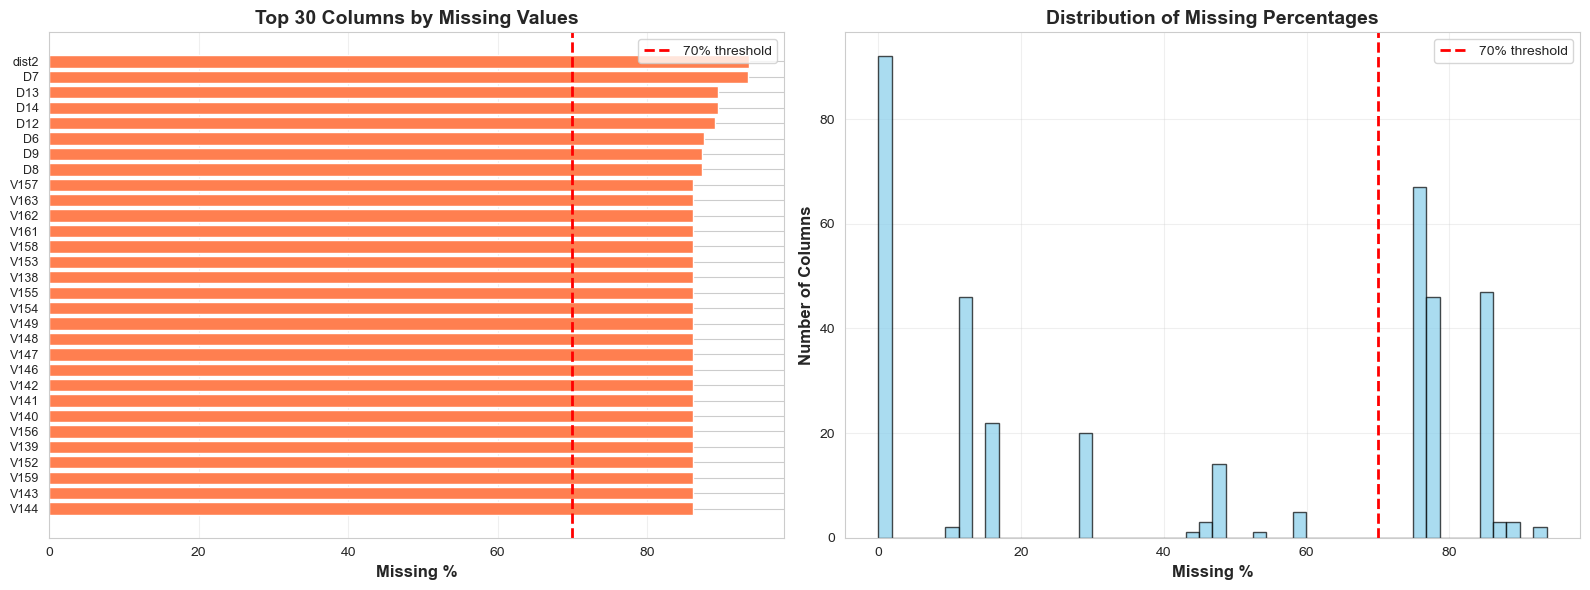


📌 CLEANING STRATEGY:
   → Drop columns with >70% missing: 168 columns
   → Impute remaining columns: 206 columns
   → Keep complete columns: 20 columns

✅ Analysis complete!


In [ ]:
"""
🔍 BLOK 5: MISSING VALUES ANALYSIS
═══════════════════════════════════════════════════════
Run time: ~20 seconds
Description: Analyze missing value patterns
"""

print("="*70)
print("🔍 MISSING VALUES ANALYSIS")
print("="*70)

# Calculate missing percentages
missing_stats = []
for col in tqdm(train_transaction.columns, desc="Analyzing columns"):
    null_count = train_transaction[col].null_count()
    null_pct = (null_count / len(train_transaction)) * 100
    if null_pct > 0:
        missing_stats.append({
            'column': col,
            'missing_count': null_count,
            'missing_pct': null_pct,
            'dtype': str(train_transaction[col].dtype)
        })

missing_df = pd.DataFrame(missing_stats).sort_values('missing_pct', ascending=False)

print(f"\n📊 SUMMARY:")
print(f"   Total columns: {len(train_transaction.columns)}")
print(f"   Columns with missing: {len(missing_df)}")
print(f"   Complete columns: {len(train_transaction.columns) - len(missing_df)}")

print(f"\n📋 TOP 20 COLUMNS WITH MOST MISSING VALUES:")
display(missing_df.head(20))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 30 missing
top_missing = missing_df.head(30)
axes[0].barh(range(len(top_missing)), top_missing['missing_pct'], color='coral')
axes[0].set_yticks(range(len(top_missing)))
axes[0].set_yticklabels(top_missing['column'], fontsize=9)
axes[0].set_xlabel('Missing %', fontsize=12, fontweight='bold')
axes[0].set_title('Top 30 Columns by Missing Values', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=70, color='red', linestyle='--', linewidth=2, label='70% threshold')
axes[0].legend()

# Distribution of missing percentages
axes[1].hist(missing_df['missing_pct'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(x=70, color='red', linestyle='--', linewidth=2, label='70% threshold')
axes[1].set_xlabel('Missing %', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Columns', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Missing Percentages', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Decision strategy
drop_threshold = 70
cols_to_drop = missing_df[missing_df['missing_pct'] > drop_threshold]['column'].tolist()

print(f"\n📌 CLEANING STRATEGY:")
print(f"   → Drop columns with >{drop_threshold}% missing: {len(cols_to_drop)} columns")
print(f"   → Impute remaining columns: {len(missing_df) - len(cols_to_drop)} columns")
print(f"   → Keep complete columns: {len(train_transaction.columns) - len(missing_df)} columns")

# Save for later use
with open('cols_to_drop.pkl', 'wb') as f:
    pickle.dump(cols_to_drop, f)

print("\n✅ Analysis complete!")

In [ ]:
"""
📊 BLOK 6: FEATURE TYPES ANALYSIS
═══════════════════════════════════════════════════════
Run time: ~10 seconds
Description: Understand data types and feature categories
"""

print("="*70)
print("📊 FEATURE TYPES ANALYSIS")
print("="*70)

# Categorize features
categorical_features = []
numerical_features = []
id_features = ['TransactionID']
target = 'isFraud'

for col in train_transaction.columns:
    if col in id_features or col == target:
        continue

    dtype = train_transaction[col].dtype

    if dtype == pl.Utf8:
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"\n📋 FEATURE BREAKDOWN:")
print(f"   Total features: {len(train_transaction.columns)}")
print(f"   - ID columns: {len(id_features)}")
print(f"   - Target: 1")
print(f"   - Numerical: {len(numerical_features)}")
print(f"   - Categorical: {len(categorical_features)}")

print(f"\n🔢 NUMERICAL FEATURES ({len(numerical_features)}):")
print(f"   {numerical_features[:10]} ... (showing first 10)")

print(f"\n📝 CATEGORICAL FEATURES ({len(categorical_features)}):")
print(f"   {categorical_features}")

# Save for later
feature_info = {
    'categorical': categorical_features,
    'numerical': numerical_features,
    'id': id_features,
    'target': target
}

with open('feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)

print("\n✅ Feature categorization complete!")

📊 FEATURE TYPES ANALYSIS

📋 FEATURE BREAKDOWN:
   Total features: 394
   - ID columns: 1
   - Target: 1
   - Numerical: 378
   - Categorical: 14

🔢 NUMERICAL FEATURES (378):
   ['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2'] ... (showing first 10)

📝 CATEGORICAL FEATURES (14):
   ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

✅ Feature categorization complete!


In [ ]:
"""
🧹 BLOK 7: DATA CLEANING
═══════════════════════════════════════════════════════
Run time: ~1-2 minutes
Description: Remove high-missing columns and impute remaining
"""

print("="*70)
print("🧹 DATA CLEANING")
print("="*70)

# Load saved info
with open('cols_to_drop.pkl', 'rb') as f:
    cols_to_drop = pickle.load(f)

with open('feature_info.pkl', 'rb') as f:
    feature_info = pickle.load(f)

print(f"\n1️⃣ DROPPING HIGH-MISSING COLUMNS...")
print(f"   Columns to drop: {len(cols_to_drop)}")

# Drop from both train and test
train_clean = train_transaction.drop(cols_to_drop)
test_clean = test_transaction.drop([c for c in cols_to_drop if c in test_transaction.columns])

print(f"   ✓ Train shape after drop: {train_clean.shape}")
print(f"   ✓ Test shape after drop: {test_clean.shape}")

print(f"\n2️⃣ IMPUTING MISSING VALUES...")

# Imputation strategy
impute_stats = {'categorical': {}, 'numerical': {}}

# Get updated categorical/numerical lists (after dropping columns)
categorical_features = [c for c in feature_info['categorical'] if c in train_clean.columns]
numerical_features = [c for c in feature_info['numerical'] if c in train_clean.columns]

# Impute categorical (mode)
print(f"   Processing {len(categorical_features)} categorical features...")
for col in tqdm(categorical_features, desc="Categorical"):
    mode_val = train_clean[col].mode().to_list()

    # ✅ FIX: Check if mode exists and is valid
    if mode_val and len(mode_val) > 0 and mode_val[0] is not None:
        mode_val = mode_val[0]
        impute_stats['categorical'][col] = mode_val
        train_clean = train_clean.with_columns(pl.col(col).fill_null(mode_val))

        # ✅ FIX: Only fill test if column exists
        if col in test_clean.columns:
            test_clean = test_clean.with_columns(pl.col(col).fill_null(mode_val))
    else:
        # ✅ FIX: If no mode, fill with "unknown"
        impute_stats['categorical'][col] = "unknown"
        train_clean = train_clean.with_columns(pl.col(col).fill_null("unknown"))

        if col in test_clean.columns:
            test_clean = test_clean.with_columns(pl.col(col).fill_null("unknown"))

# Impute numerical (median - robust to outliers)
print(f"   Processing {len(numerical_features)} numerical features...")
for col in tqdm(numerical_features, desc="Numerical"):
    if col in ['TransactionID', 'TransactionDT']:
        continue

    median_val = train_clean[col].median()

    # ✅ FIX: Check if median is valid
    if median_val is not None:
        impute_stats['numerical'][col] = float(median_val)
        train_clean = train_clean.with_columns(pl.col(col).fill_null(median_val))

        # ✅ FIX: Only fill test if column exists
        if col in test_clean.columns:
            test_clean = test_clean.with_columns(pl.col(col).fill_null(median_val))
    else:
        # ✅ FIX: If no median, fill with 0
        impute_stats['numerical'][col] = 0.0
        train_clean = train_clean.with_columns(pl.col(col).fill_null(0.0))

        if col in test_clean.columns:
            test_clean = test_clean.with_columns(pl.col(col).fill_null(0.0))

# Save imputation stats
with open('impute_stats.pkl', 'wb') as f:
    pickle.dump(impute_stats, f)

# Verify
remaining_missing_train = sum(train_clean[col].null_count() for col in train_clean.columns)
remaining_missing_test = sum(test_clean[col].null_count() for col in test_clean.columns)

print(f"\n3️⃣ VERIFICATION:")
print(f"   Train remaining missing: {remaining_missing_train}")
print(f"   Test remaining missing: {remaining_missing_test}")

print("\n" + "="*70)
print("✅ DATA CLEANING COMPLETE!")
print("="*70)
print(f"Final shapes:")
print(f"   Train: {train_clean.shape}")
print(f"   Test: {test_clean.shape}")

🧹 DATA CLEANING

1️⃣ DROPPING HIGH-MISSING COLUMNS...
   Columns to drop: 168
   ✓ Train shape after drop: (590540, 226)
   ✓ Test shape after drop: (506691, 225)

2️⃣ IMPUTING MISSING VALUES...
   Processing 13 categorical features...


Categorical:   0%|          | 0/13 [00:00<?, ?it/s]

   Processing 211 numerical features...


Numerical:   0%|          | 0/211 [00:00<?, ?it/s]


3️⃣ VERIFICATION:
   Train remaining missing: 0
   Test remaining missing: 0

✅ DATA CLEANING COMPLETE!
Final shapes:
   Train: (590540, 226)
   Test: (506691, 225)


In [ ]:
"""
💾 BLOK 8: SAVE CLEANED DATA
═══════════════════════════════════════════════════════
Run time: ~30 seconds
Description: Save cleaned data for next phase
"""

print("💾 Saving cleaned data...")

train_clean.write_csv(f"{BASE_PATH}/train_cleaned.csv")
test_clean.write_csv(f"{BASE_PATH}/test_cleaned.csv")

print("✅ Cleaned data saved!")
print(f"   {BASE_PATH}/train_cleaned.csv")
print(f"   {BASE_PATH}/test_cleaned.csv")

# Memory cleanup
del train_transaction, test_transaction
gc.collect()

print("\n📌 CHECKPOINT: Data cleaning complete!")
print("   You can now proceed to Feature Engineering (Blok 9)")

💾 Saving cleaned data...
✅ Cleaned data saved!
   C:\Users\hamda\OneDrive\Documents\SEMESTER 7\MACHINE LEARNING\fraud\transaction/train_cleaned.csv
   C:\Users\hamda\OneDrive\Documents\SEMESTER 7\MACHINE LEARNING\fraud\transaction/test_cleaned.csv

📌 CHECKPOINT: Data cleaning complete!
   You can now proceed to Feature Engineering (Blok 9)


In [ ]:
"""
🔧 BLOK 9: ADVANCED FEATURE ENGINEERING
═══════════════════════════════════════════════════════
Run time: ~5-10 minutes
Description: Create ~60 domain-specific features for fraud detection

⚠️ THIS IS THE MOST IMPORTANT BLOCK FOR PERFORMANCE!
   These features capture fraud patterns:
   - Velocity: How fast are transactions happening?
   - Deviation: Is this unusual for this user?
   - Aggregation: Group-level patterns
   - Interaction: Feature combinations
"""

def engineer_fraud_features(df, is_train=True):
    """
    Complete feature engineering pipeline.
    Creates ~60 new features optimized for fraud detection.
    """

    print("="*70)
    print("🔧 ADVANCED FEATURE ENGINEERING")
    print("="*70)
    print(f"Input shape: {df.shape}")
    print(f"Mode: {'TRAIN' if is_train else 'TEST'}")
    print()

    # ================================================================
    # 1. TEMPORAL FEATURES
    # ================================================================
    print("[1/6] Creating temporal features...")

    # Basic time components
    df = df.with_columns([
        (pl.col('TransactionDT') // 3600 % 24).cast(pl.Int16).alias('hour'),
        (pl.col('TransactionDT') // (3600 * 24) % 7).cast(pl.Int16).alias('day_of_week'),
        (pl.col('TransactionDT') // (3600 * 24)).cast(pl.Int32).alias('day_of_year'),
        (pl.col('TransactionDT') // 3600).cast(pl.Int32).alias('hour_window'),
        (pl.col('TransactionDT') // (3600 * 24)).cast(pl.Int32).alias('day_window')
    ])

    # Cyclical encoding (CRITICAL for neural networks!)
    df = df.with_columns([
        (pl.col('hour') * 2 * np.pi / 24).sin().cast(pl.Float32).alias('hour_sin'),
        (pl.col('hour') * 2 * np.pi / 24).cos().cast(pl.Float32).alias('hour_cos'),
        (pl.col('day_of_week') * 2 * np.pi / 7).sin().cast(pl.Float32).alias('dow_sin'),
        (pl.col('day_of_week') * 2 * np.pi / 7).cos().cast(pl.Float32).alias('dow_cos')
    ])

    # High-risk time indicators
    df = df.with_columns([
        ((pl.col('hour') >= 0) & (pl.col('hour') <= 5)).cast(pl.Int8).alias('is_night'),
        ((pl.col('hour') >= 9) & (pl.col('hour') <= 17)).cast(pl.Int8).alias('is_business_hours'),
        ((pl.col('day_of_week') >= 5)).cast(pl.Int8).alias('is_weekend')
    ])

    print("   ✓ Created 14 temporal features")

    # ================================================================
    # 2. VELOCITY FEATURES (Most Important!)
    # ================================================================
    print("[2/6] Creating velocity features...")

    card_cols = ['card1', 'card2', 'card3']

    for card_col in card_cols:
        if card_col in df.columns:
            # Transactions per hour
            df = df.with_columns([
                pl.col('TransactionID').count().over([card_col, 'hour_window']).cast(pl.Int16).alias(f'{card_col}_txn_per_hour'),
                pl.col('TransactionAmt').sum().over([card_col, 'hour_window']).cast(pl.Float32).alias(f'{card_col}_amt_per_hour')
            ])

            # Transactions per day
            df = df.with_columns([
                pl.col('TransactionID').count().over([card_col, 'day_window']).cast(pl.Int16).alias(f'{card_col}_txn_per_day'),
                pl.col('TransactionAmt').sum().over([card_col, 'day_window']).cast(pl.Float32).alias(f'{card_col}_amt_per_day')
            ])

            # Average per transaction in window
            df = df.with_columns([
                (pl.col(f'{card_col}_amt_per_hour') / (pl.col(f'{card_col}_txn_per_hour') + 1)).cast(pl.Float32).alias(f'{card_col}_avg_amt_per_txn')
            ])

    print("   ✓ Created ~15 velocity features")

    # ================================================================
    # 3. DEVIATION FEATURES
    # ================================================================
    print("[3/6] Creating deviation features...")

    for card_col in ['card1', 'card2']:
        if card_col in df.columns:
            # User statistics
            df = df.with_columns([
                pl.col('TransactionAmt').mean().over(card_col).cast(pl.Float32).alias(f'{card_col}_amt_mean'),
                pl.col('TransactionAmt').std().over(card_col).cast(pl.Float32).alias(f'{card_col}_amt_std'),
                pl.col('TransactionAmt').min().over(card_col).cast(pl.Float32).alias(f'{card_col}_amt_min'),
                pl.col('TransactionAmt').max().over(card_col).cast(pl.Float32).alias(f'{card_col}_amt_max'),
                pl.col('TransactionAmt').median().over(card_col).cast(pl.Float32).alias(f'{card_col}_amt_median')
            ])

            # Deviation metrics
            df = df.with_columns([
                # Z-score
                ((pl.col('TransactionAmt') - pl.col(f'{card_col}_amt_mean')) /
                 (pl.col(f'{card_col}_amt_std') + 0.001)).cast(pl.Float32).alias(f'{card_col}_amt_zscore'),

                # Ratio to mean
                (pl.col('TransactionAmt') / (pl.col(f'{card_col}_amt_mean') + 1)).cast(pl.Float32).alias(f'{card_col}_amt_ratio'),

                # Is max transaction
                (pl.col('TransactionAmt') == pl.col(f'{card_col}_amt_max')).cast(pl.Int8).alias(f'{card_col}_is_max_amt')
            ])

    print("   ✓ Created ~16 deviation features")

    # ================================================================
    # 4. AGGREGATION FEATURES
    # ================================================================
    print("[4/6] Creating aggregation features...")

    # Product stats
    if 'ProductCD' in df.columns:
        df = df.with_columns([
            pl.col('TransactionAmt').mean().over('ProductCD').cast(pl.Float32).alias('product_amt_mean'),
            pl.col('TransactionAmt').std().over('ProductCD').cast(pl.Float32).alias('product_amt_std'),
            pl.col('TransactionID').count().over('ProductCD').cast(pl.Int32).alias('product_txn_count')
        ])

    # Address stats
    for addr_col in ['addr1', 'addr2']:
        if addr_col in df.columns:
            df = df.with_columns([
                pl.col('TransactionID').count().over(addr_col).cast(pl.Int32).alias(f'{addr_col}_txn_count'),
                pl.col('TransactionAmt').mean().over(addr_col).cast(pl.Float32).alias(f'{addr_col}_amt_mean')
            ])

    # Email domain stats
    if 'P_emaildomain' in df.columns:
        df = df.with_columns([
            pl.col('TransactionID').count().over('P_emaildomain').cast(pl.Int32).alias('email_txn_count'),
            pl.col('TransactionAmt').mean().over('P_emaildomain').cast(pl.Float32).alias('email_amt_mean')
        ])

    print("   ✓ Created ~10 aggregation features")

    # ================================================================
    # 5. INTERACTION FEATURES
    # ================================================================
    print("[5/6] Creating interaction features...")

    # Amount + Time interactions
    df = df.with_columns([
        (pl.col('TransactionAmt') * pl.col('is_night')).cast(pl.Float32).alias('amt_night_interaction'),
        (pl.col('TransactionAmt') / (pl.col('hour') + 1)).cast(pl.Float32).alias('amt_per_hour_interaction'),
        (pl.col('TransactionAmt') * pl.col('is_weekend')).cast(pl.Float32).alias('amt_weekend_interaction')
    ])

    print("   ✓ Created ~3 interaction features")

    # ================================================================
    # 6. MISSING INDICATORS
    # ================================================================
    print("[6/6] Creating missing indicators...")

    # Important field indicators
    important_cols = ['card1', 'card2', 'addr1', 'P_emaildomain', 'dist1']
    missing_count = 0

    for col in important_cols:
        if col in df.columns:
            df = df.with_columns([
                pl.col(col).is_null().cast(pl.Int8).alias(f'{col}_is_missing')
            ])
            missing_count += 1

    print(f"   ✓ Created {missing_count} missing indicators")

    # ================================================================
    # CLEANUP
    # ================================================================
    print("\n🧹 Cleaning up temporary columns...")

    temp_cols = ['hour_window', 'day_window']
    df = df.drop([c for c in temp_cols if c in df.columns])

    # Fill any remaining nulls
    for col in df.columns:
        if col not in ['TransactionID', 'isFraud', 'TransactionDT']:
            if df[col].dtype in [pl.Float32, pl.Float64, pl.Int8, pl.Int16, pl.Int32, pl.Int64]:
                df = df.with_columns([pl.col(col).fill_null(0)])

    print("="*70)
    print("✅ FEATURE ENGINEERING COMPLETE!")
    print(f"   Input features: ~{len(train_clean.columns)}")
    print(f"   New features: ~{len(df.columns) - len(train_clean.columns)}")
    print(f"   Total features: {len(df.columns)}")
    print(f"   Final shape: {df.shape}")
    print("="*70)

    return df

# ================================================================
# APPLY FEATURE ENGINEERING
# ================================================================

print("\n🚀 APPLYING FEATURE ENGINEERING TO TRAIN DATA...")
train_engineered = engineer_fraud_features(train_clean, is_train=True)

print("\n🚀 APPLYING FEATURE ENGINEERING TO TEST DATA...")
test_engineered = engineer_fraud_features(test_clean, is_train=False)

# Save engineered data
print("\n💾 Saving engineered data...")
train_engineered.write_csv(f"{BASE_PATH}/train_engineered.csv")
test_engineered.write_csv(f"{BASE_PATH}/test_engineered.csv")

print("✅ Engineered data saved!")

# Memory cleanup
del train_clean, test_clean
gc.collect()

print("\n📌 CHECKPOINT: Feature engineering complete!")
print("   Total new features created: ~60")
print("   Ready for preprocessing (Blok 10)")


🚀 APPLYING FEATURE ENGINEERING TO TRAIN DATA...
🔧 ADVANCED FEATURE ENGINEERING
Input shape: (590540, 226)
Mode: TRAIN

[1/6] Creating temporal features...
   ✓ Created 14 temporal features
[2/6] Creating velocity features...
   ✓ Created ~15 velocity features
[3/6] Creating deviation features...
   ✓ Created ~16 deviation features
[4/6] Creating aggregation features...
   ✓ Created ~10 aggregation features
[5/6] Creating interaction features...
   ✓ Created ~3 interaction features
[6/6] Creating missing indicators...
   ✓ Created 5 missing indicators

🧹 Cleaning up temporary columns...
✅ FEATURE ENGINEERING COMPLETE!
   Input features: ~226
   New features: ~58
   Total features: 284
   Final shape: (590540, 284)

🚀 APPLYING FEATURE ENGINEERING TO TEST DATA...
🔧 ADVANCED FEATURE ENGINEERING
Input shape: (506691, 225)
Mode: TEST

[1/6] Creating temporal features...
   ✓ Created 14 temporal features
[2/6] Creating velocity features...
   ✓ Created ~15 velocity features
[3/6] Creating de

In [ ]:
"""
✂️ BLOK 10: TRAIN/VALIDATION SPLIT
═══════════════════════════════════════════════════════
Run time: ~1 minute
Description: Split data with STRATIFIED sampling (CRITICAL!)
"""

print("="*70)
print("✂️ TRAIN/VALIDATION SPLIT")
print("="*70)

# Convert to pandas for sklearn compatibility
print("\n1️⃣ Converting to Pandas...")
train_df = train_engineered.to_pandas()

print(f"   ✓ Shape: {train_df.shape}")
print(f"   ✓ Memory: {train_df.memory_usage().sum() / 1024**2:.2f} MB")

# Separate features and target
print("\n2️⃣ Separating features and target...")

# Columns to drop
drop_cols = ['TransactionID', 'TransactionDT', 'isFraud']

X = train_df.drop(columns=drop_cols)
y = train_df['isFraud']

print(f"   ✓ Features shape: {X.shape}")
print(f"   ✓ Target shape: {y.shape}")
print(f"   ✓ Target distribution: {y.value_counts().to_dict()}")

# Identify categorical columns for later encoding
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n   Feature types:")
print(f"   - Numerical: {len(numerical_cols)}")
print(f"   - Categorical: {len(categorical_cols)}")
print(f"   - Categorical columns: {categorical_cols}")

# CRITICAL: Stratified split (ensures fraud distribution in both train/val)
print("\n3️⃣ Performing STRATIFIED split...")
print("   ⚠️ Using stratified split to maintain fraud distribution!")

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # CRITICAL!
    random_state=RANDOM_STATE
)

print(f"\n   ✓ Train set: {X_train.shape}")
print(f"     - Not Fraud: {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"     - Fraud: {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")

print(f"\n   ✓ Validation set: {X_val.shape}")
print(f"     - Not Fraud: {(y_val==0).sum():,} ({(y_val==0).sum()/len(y_val)*100:.2f}%)")
print(f"     - Fraud: {(y_val==1).sum():,} ({(y_val==1).sum()/len(y_val)*100:.2f}%)")

# Save split info
split_info = {
    'categorical_cols': categorical_cols,
    'numerical_cols': numerical_cols,
    'train_shape': X_train.shape,
    'val_shape': X_val.shape
}

with open('split_info.pkl', 'wb') as f:
    pickle.dump(split_info, f)

print("\n✅ Split complete!")

✂️ TRAIN/VALIDATION SPLIT

1️⃣ Converting to Pandas...
   ✓ Shape: (590540, 284)
   ✓ Memory: 1122.99 MB

2️⃣ Separating features and target...
   ✓ Features shape: (590540, 281)
   ✓ Target shape: (590540,)
   ✓ Target distribution: {0: 569877, 1: 20663}

   Feature types:
   - Numerical: 268
   - Categorical: 13
   - Categorical columns: ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

3️⃣ Performing STRATIFIED split...
   ⚠️ Using stratified split to maintain fraud distribution!

   ✓ Train set: (472432, 281)
     - Not Fraud: 455,902 (96.50%)
     - Fraud: 16,530 (3.50%)

   ✓ Validation set: (118108, 281)
     - Not Fraud: 113,975 (96.50%)
     - Fraud: 4,133 (3.50%)

✅ Split complete!


⚖️ SMOTE + FEATURE PREPROCESSING

1️⃣ ENCODING CATEGORICAL FEATURES...
   Processing 13 categorical columns...
   ✓ Encoded 13 categorical features

2️⃣ SCALING NUMERICAL FEATURES...
   Using RobustScaler (robust to outliers)
   ✓ Scaled 281 features

3️⃣ APPLYING SMOTE...
   ⚠️ This will take 1-2 minutes...

   Before SMOTE:
   - Not Fraud: 455,902
   - Fraud: 16,530
   - Ratio: 27.6:1

   After SMOTE:
   - Not Fraud: 455,902
   - Fraud: 136,770
   - Ratio: 3.3:1
   - Total samples: 592,672 (increased from 472,432)


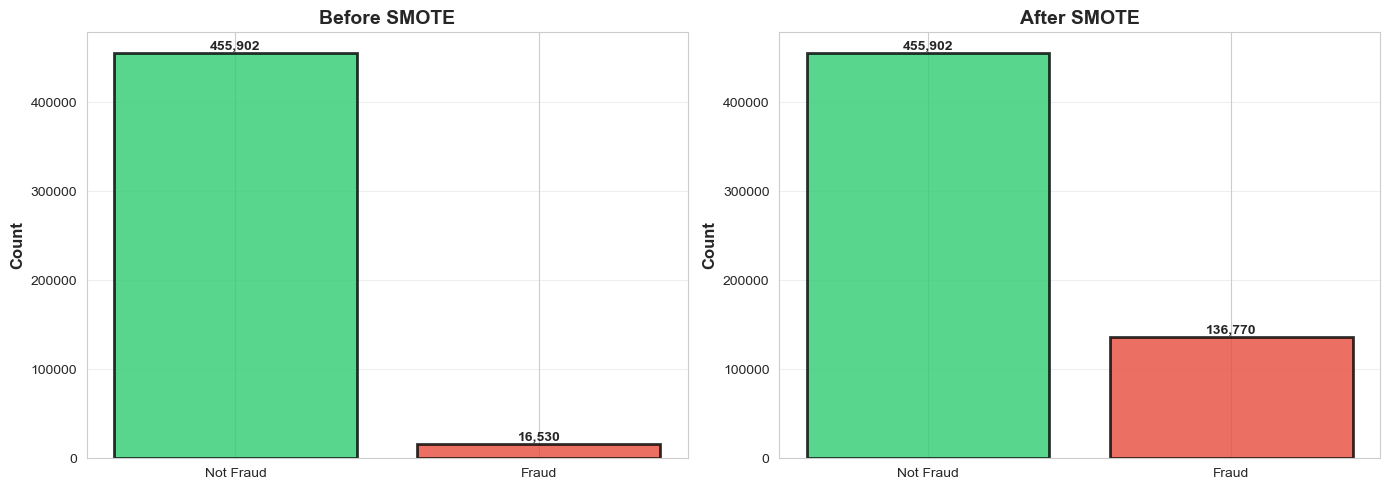


💾 Saving preprocessed data for later use...
   ✓ Saved: X_train_smote, y_train_smote, X_val_scaled, y_val

✅ PREPROCESSING COMPLETE!
Ready for model training!


In [ ]:
"""
⚖️ BLOK 11: SMOTE + PREPROCESSING
═══════════════════════════════════════════════════════
Run time: ~2-3 minutes
Description: Handle class imbalance with SMOTE and scale features
"""

print("="*70)
print("⚖️ SMOTE + FEATURE PREPROCESSING")
print("="*70)

# Load split info
with open('split_info.pkl', 'rb') as f:
    split_info = pickle.load(f)

categorical_cols = split_info['categorical_cols']
numerical_cols = split_info['numerical_cols']

# ================================================================
# 1. CATEGORICAL ENCODING
# ================================================================
print("\n1️⃣ ENCODING CATEGORICAL FEATURES...")

if len(categorical_cols) > 0:
    print(f"   Processing {len(categorical_cols)} categorical columns...")

    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()

        # Fit on train
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_val[col] = le.transform(X_val[col].astype(str))

        label_encoders[col] = le

    # Save encoders
    with open('label_encoders.pkl', 'wb') as f:
        pickle.dump(label_encoders, f)

    print(f"   ✓ Encoded {len(categorical_cols)} categorical features")
else:
    print("   ✓ No categorical features to encode")

# ================================================================
# 2. FEATURE SCALING
# ================================================================
print("\n2️⃣ SCALING NUMERICAL FEATURES...")
print("   Using RobustScaler (robust to outliers)")

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"   ✓ Scaled {X_train.shape[1]} features")

# ================================================================
# 3. SMOTE (CRITICAL for imbalanced data!)
# ================================================================
print("\n3️⃣ APPLYING SMOTE...")
print("   ⚠️ This will take 1-2 minutes...")

# Check current distribution
print(f"\n   Before SMOTE:")
print(f"   - Not Fraud: {(y_train==0).sum():,}")
print(f"   - Fraud: {(y_train==1).sum():,}")
print(f"   - Ratio: {(y_train==0).sum()/(y_train==1).sum():.1f}:1")

# ✅ FIX: Remove n_jobs parameter (not supported in newer versions)
smote = SMOTE(
    sampling_strategy=0.3,  # Increase fraud to 30% of majority
    random_state=RANDOM_STATE
    # n_jobs removed - not supported
)

X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print(f"\n   After SMOTE:")
print(f"   - Not Fraud: {(y_train_smote==0).sum():,}")
print(f"   - Fraud: {(y_train_smote==1).sum():,}")
print(f"   - Ratio: {(y_train_smote==0).sum()/(y_train_smote==1).sum():.1f}:1")
print(f"   - Total samples: {len(X_train_smote):,} (increased from {len(X_train):,})")

# Visualize SMOTE effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
y_train_counts = pd.Series(y_train).value_counts()
axes[0].bar(['Not Fraud', 'Fraud'], [y_train_counts[0], y_train_counts[1]],
            color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)
axes[0].set_title('Before SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate([y_train_counts[0], y_train_counts[1]]):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# After SMOTE
y_smote_counts = pd.Series(y_train_smote).value_counts()
axes[1].bar(['Not Fraud', 'Fraud'], [y_smote_counts[0], y_smote_counts[1]],
            color=['#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black', linewidth=2)
axes[1].set_title('After SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate([y_smote_counts[0], y_smote_counts[1]]):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ✅ BONUS: Save SMOTE data for later blocks (Blok 13, 14, etc.)
print("\n💾 Saving preprocessed data for later use...")
with open('X_train_smote.pkl', 'wb') as f:
    pickle.dump(X_train_smote, f)
with open('y_train_smote.pkl', 'wb') as f:
    pickle.dump(y_train_smote, f)
with open('X_val_scaled.pkl', 'wb') as f:
    pickle.dump(X_val_scaled, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)

print("   ✓ Saved: X_train_smote, y_train_smote, X_val_scaled, y_val")

print("\n" + "="*70)
print("✅ PREPROCESSING COMPLETE!")
print("="*70)
print("Ready for model training!")

🚀 MODEL 1: LIGHTGBM BASELINE

📋 Parameters:
   objective: binary
   metric: auc
   boosting_type: gbdt
   learning_rate: 0.05
   num_leaves: 31
   max_depth: 7
   min_child_samples: 20
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 0.1
   reg_lambda: 0.1
   random_state: 42
   n_jobs: -1
   verbose: -1

1️⃣ Creating LightGBM datasets...

2️⃣ Training model...
   ⏳ This will take 2-3 minutes...
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.97917	valid's auc: 0.877169
[100]	train's auc: 0.986584	valid's auc: 0.891728
[150]	train's auc: 0.988695	valid's auc: 0.902807
[200]	train's auc: 0.990007	valid's auc: 0.91113
[250]	train's auc: 0.990971	valid's auc: 0.916929
[300]	train's auc: 0.991749	valid's auc: 0.921927
[350]	train's auc: 0.992503	valid's auc: 0.92705
[400]	train's auc: 0.99319	valid's auc: 0.93162
[450]	train's auc: 0.993684	valid's auc: 0.934169
[500]	train's auc: 0.994141	valid's auc: 0.936494
[550]	train's auc: 0.994588	valid's au

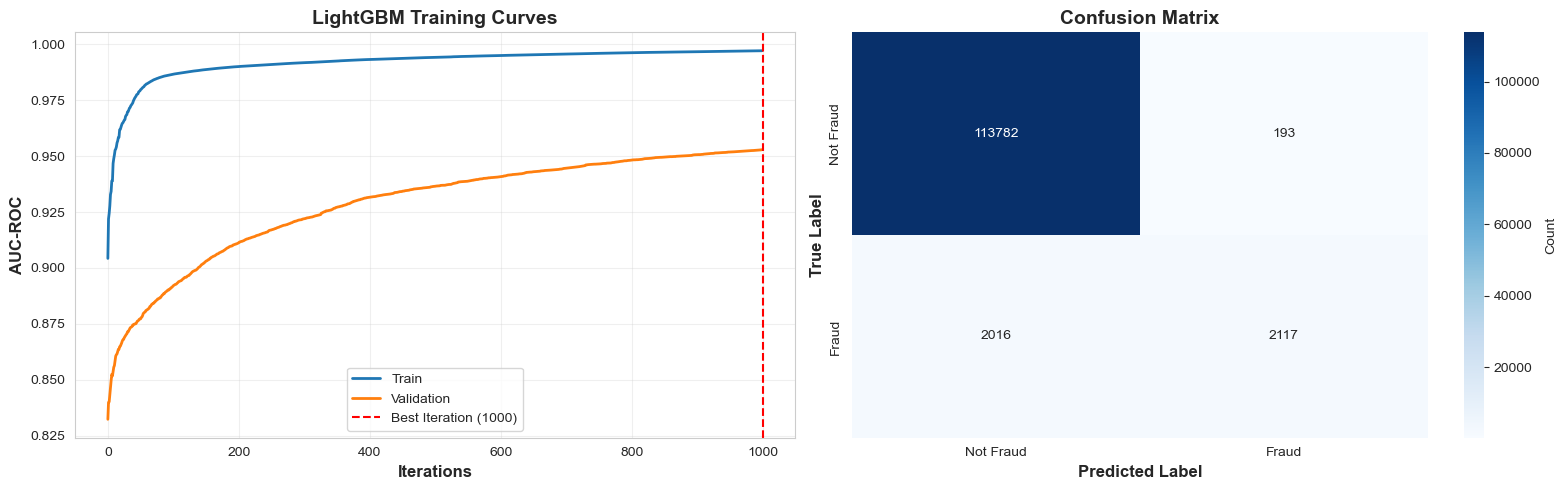


✅ LightGBM Baseline complete!


In [ ]:
"""
🚀 BLOK 12: LIGHTGBM BASELINE
═══════════════════════════════════════════════════════
Run time: ~3-5 minutes
Description: Train LightGBM with default good parameters
"""

print("="*70)
print("🚀 MODEL 1: LIGHTGBM BASELINE")
print("="*70)

# Best parameters from experience (no tuning yet)
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': 7,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

print("\n📋 Parameters:")
for k, v in lgb_params.items():
    print(f"   {k}: {v}")

# Create datasets
print("\n1️⃣ Creating LightGBM datasets...")
dtrain = lgb.Dataset(X_train_smote, label=y_train_smote)
dval = lgb.Dataset(X_val_scaled, label=y_val, reference=dtrain)

# Train with early stopping
print("\n2️⃣ Training model...")
print("   ⏳ This will take 2-3 minutes...")

# ✅ FIX: Use record_evaluation callback instead of evals_result parameter
evals_result = {}
callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=50),
    lgb.record_evaluation(evals_result)  # ← Records training history
]

lgb_baseline = lgb.train(
    lgb_params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=callbacks  # ← Callbacks now include record_evaluation
)

print(f"\n   ✓ Best iteration: {lgb_baseline.best_iteration}")
print(f"   ✓ Best score: {lgb_baseline.best_score['valid']['auc']:.4f}")

# ================================================================
# EVALUATION
# ================================================================
print("\n3️⃣ EVALUATION:")

# Predictions
y_train_pred = lgb_baseline.predict(X_train_smote)
y_val_pred = lgb_baseline.predict(X_val_scaled)

# Metrics
train_auc_roc = roc_auc_score(y_train_smote, y_train_pred)
train_auc_pr = average_precision_score(y_train_smote, y_train_pred)

val_auc_roc = roc_auc_score(y_val, y_val_pred)
val_auc_pr = average_precision_score(y_val, y_val_pred)

print(f"\n   📊 TRAIN METRICS:")
print(f"      AUC-ROC: {train_auc_roc:.4f}")
print(f"      AUC-PR:  {train_auc_pr:.4f}")

print(f"\n   📊 VALIDATION METRICS:")
print(f"      AUC-ROC: {val_auc_roc:.4f}")
print(f"      AUC-PR:  {val_auc_pr:.4f}")

# Classification report at threshold 0.5
y_val_pred_binary = (y_val_pred > 0.5).astype(int)
print(f"\n   📋 CLASSIFICATION REPORT (threshold=0.5):")
print(classification_report(y_val, y_val_pred_binary,
                           target_names=['Not Fraud', 'Fraud'],
                           digits=4))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred_binary)
print(f"\n   🔢 CONFUSION MATRIX:")
print(f"      [[TN={cm[0,0]:,}  FP={cm[0,1]:,}]")
print(f"       [FN={cm[1,0]:,}  TP={cm[1,1]:,}]]")

# Visualize training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training curves
axes[0].plot(evals_result['train']['auc'], label='Train', linewidth=2)
axes[0].plot(evals_result['valid']['auc'], label='Validation', linewidth=2)
axes[0].axvline(x=lgb_baseline.best_iteration, color='red', linestyle='--',
               label=f'Best Iteration ({lgb_baseline.best_iteration})')
axes[0].set_xlabel('Iterations', fontsize=12, fontweight='bold')
axes[0].set_ylabel('AUC-ROC', fontsize=12, fontweight='bold')
axes[0].set_title('LightGBM Training Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud'],
           cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Save model
lgb_baseline.save_model('lgb_baseline.txt')

# Save results
lgb_results = {
    'model_name': 'LightGBM Baseline',
    'train_auc_roc': train_auc_roc,
    'train_auc_pr': train_auc_pr,
    'val_auc_roc': val_auc_roc,
    'val_auc_pr': val_auc_pr,
    'best_iteration': lgb_baseline.best_iteration,
    'params': lgb_params
}

with open('lgb_baseline_results.pkl', 'wb') as f:
    pickle.dump(lgb_results, f)

print("\n✅ LightGBM Baseline complete!")

In [ ]:
"""
🎯 BLOK 13: LIGHTGBM HYPERPARAMETER TUNING
═══════════════════════════════════════════════════════
Run time: ~15-30 minutes (depending on n_trials)
Description: Optimize LightGBM hyperparameters with Optuna
"""

RUN_OPTUNA = True  # Set to False to skip

if RUN_OPTUNA:
    print("="*70)
    print("🎯 LIGHTGBM HYPERPARAMETER TUNING WITH OPTUNA")
    print("="*70)

    # Load preprocessed data
    print("\n1️⃣ Loading preprocessed data...")

    if 'X_train_smote' not in globals():
        print("   ⚠️ Loading from saved files...")
        with open('X_train_smote.pkl', 'rb') as f:
            X_train_smote = pickle.load(f)
        with open('y_train_smote.pkl', 'rb') as f:
            y_train_smote = pickle.load(f)
        with open('X_val_scaled.pkl', 'rb') as f:
            X_val_scaled = pickle.load(f)
        with open('y_val.pkl', 'rb') as f:
            y_val = pickle.load(f)

    print(f"   ✓ Using SMOTE data: {len(X_train_smote):,} samples")

    # Create LightGBM datasets
    print("\n2️⃣ Creating LightGBM datasets for Optuna...")
    dtrain = lgb.Dataset(X_train_smote, label=y_train_smote)
    dval = lgb.Dataset(X_val_scaled, label=y_val, reference=dtrain)
    print("   ✓ Datasets created")

    def objective_lgb(trial):
        """
        Optuna objective function for LightGBM.
        """
        params = {
            'objective': 'binary',
            'metric': 'auc',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'feature_pre_filter': False,  # ✅ FIX: Allow dynamic min_child_samples
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'random_state': RANDOM_STATE,
            'n_jobs': -1
        }

        # ✅ FIX: Use callbacks properly for new LightGBM API
        callbacks = [
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0)  # Silent training
        ]

        model = lgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            valid_sets=[dval],
            callbacks=callbacks
        )

        # Evaluate
        y_pred = model.predict(X_val_scaled)
        score = average_precision_score(y_val, y_pred)

        return score

    # Run optimization
    print("\n3️⃣ Running Optuna optimization...")
    print("   This will take 15-30 minutes for 50 trials...")
    print("   Feel free to reduce n_trials if needed!\n")

    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE)
    )

    study.optimize(objective_lgb, n_trials=20, show_progress_bar=True)

    print("\n" + "="*70)
    print("📊 OPTIMIZATION RESULTS")
    print("="*70)
    print(f"Best AUC-PR: {study.best_value:.4f}")
    print(f"\nBest Parameters:")
    for k, v in study.best_params.items():
        print(f"   {k}: {v}")

    # Visualize optimization
    try:
        fig = plot_optimization_history(study)
        fig.show()

        fig = plot_param_importances(study)
        fig.show()
    except:
        print("   ⚠️ Visualization skipped (plotly might not be available)")

    # Train final model with best params
    print("\n4️⃣ Training final model with best parameters...")

    best_params = study.best_params
    best_params.update({
        'objective': 'binary',
        'metric': 'auc',
        'feature_pre_filter': False,  # ✅ Keep this for final model too
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'verbose': -1
    })

    # ✅ FIX: Use callbacks for final training
    evals_result = {}
    callbacks_final = [
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50),
        lgb.record_evaluation(evals_result)
    ]

    lgb_tuned = lgb.train(
        best_params,
        dtrain,
        num_boost_round=1000,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'valid'],
        callbacks=callbacks_final
    )

    # Evaluate tuned model
    y_val_pred_tuned = lgb_tuned.predict(X_val_scaled)

    val_auc_roc_tuned = roc_auc_score(y_val, y_val_pred_tuned)
    val_auc_pr_tuned = average_precision_score(y_val, y_val_pred_tuned)

    print(f"\n📊 TUNED MODEL VALIDATION METRICS:")
    print(f"   AUC-ROC: {val_auc_roc_tuned:.4f}")
    print(f"   AUC-PR:  {val_auc_pr_tuned:.4f}")

    # Compare with baseline
    print(f"\n📈 IMPROVEMENT:")
    print(f"   AUC-ROC: {val_auc_roc:.4f} → {val_auc_roc_tuned:.4f} ({val_auc_roc_tuned-val_auc_roc:+.4f})")
    print(f"   AUC-PR:  {val_auc_pr:.4f} → {val_auc_pr_tuned:.4f} ({val_auc_pr_tuned-val_auc_pr:+.4f})")

    # Save tuned model
    lgb_tuned.save_model('lgb_tuned.txt')

    lgb_tuned_results = {
        'model_name': 'LightGBM Tuned',
        'val_auc_roc': val_auc_roc_tuned,
        'val_auc_pr': val_auc_pr_tuned,
        'best_params': best_params,
        'study': study
    }

    with open('lgb_tuned_results.pkl', 'wb') as f:
        pickle.dump(lgb_tuned_results, f)

    print("\n✅ Optuna tuning complete!")

else:
    print("⏭️ Skipping Optuna tuning (RUN_OPTUNA = False)")
    print("   Using baseline LightGBM as best model")

[I 2025-12-31 01:15:57,562] A new study created in memory with name: no-name-b08c04b0-6b60-4c5a-8314-2b846c3423d6


🎯 LIGHTGBM HYPERPARAMETER TUNING WITH OPTUNA

1️⃣ Loading preprocessed data...
   ✓ Using SMOTE data: 592,672 samples

2️⃣ Creating LightGBM datasets for Optuna...
   ✓ Datasets created

3️⃣ Running Optuna optimization...
   This will take 15-30 minutes for 50 trials...
   Feel free to reduce n_trials if needed!



  0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.958555
[I 2025-12-31 01:17:34,438] Trial 0 finished with value: 0.7751708945229568 and parameters: {'learning_rate': 0.023688639503640783, 'num_leaves': 97, 'max_depth': 10, 'min_child_samples': 64, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.7751708945229568.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.902533
[I 2025-12-31 01:18:03,511] Trial 1 finished with value: 0.5654696685997279 and parameters: {'learning_rate': 0.039913058785616795, 'num_leaves': 77, 'max_depth': 3, 'min_child_samples': 98, 'subsample': 0.9329770563201687, 'colsample_bytree': 0.6849356442713105, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07


4️⃣ Training final model with best parameters...
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.987058	valid's auc: 0.898548
[100]	train's auc: 0.991966	valid's auc: 0.922032
[150]	train's auc: 0.994225	valid's auc: 0.93706
[200]	train's auc: 0.995602	valid's auc: 0.945409
[250]	train's auc: 0.996597	valid's auc: 0.950581
[300]	train's auc: 0.997319	valid's auc: 0.954018
[350]	train's auc: 0.997895	valid's auc: 0.956776
[400]	train's auc: 0.998362	valid's auc: 0.959569
[450]	train's auc: 0.998694	valid's auc: 0.9615
[500]	train's auc: 0.998997	valid's auc: 0.963084
[550]	train's auc: 0.999238	valid's auc: 0.964594
[600]	train's auc: 0.999388	valid's auc: 0.965385
[650]	train's auc: 0.99951	valid's auc: 0.966282
[700]	train's auc: 0.999621	valid's auc: 0.96691
[750]	train's auc: 0.999709	valid's auc: 0.967529
[800]	train's auc: 0.999766	valid's auc: 0.968158
[850]	train's auc: 0.999819	valid's auc: 0.968667
[900]	train's auc: 0.999859	valid's auc: 0.96

In [ ]:
"""
🚀 BLOK 14: XGBOOST MODEL
═══════════════════════════════════════════════════════
Run time: ~3-5 minutes
Description: Train XGBoost for model comparison
"""

print("="*70)
print("🚀 MODEL 2: XGBOOST")
print("="*70)

# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 7,
    'min_child_weight': 1,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'tree_method': 'hist'
}

print("\n📋 Parameters:")
for k, v in xgb_params.items():
    print(f"   {k}: {v}")

# Create DMatrix
print("\n1️⃣ Creating XGBoost datasets...")
dtrain_xgb = xgb.DMatrix(X_train_smote, label=y_train_smote)
dval_xgb = xgb.DMatrix(X_val_scaled, label=y_val)

# Train
print("\n2️⃣ Training model...")
evals_result_xgb = {}
xgb_model = xgb.train(
    xgb_params,
    dtrain_xgb,
    num_boost_round=1000,
    evals=[(dtrain_xgb, 'train'), (dval_xgb, 'valid')],
    evals_result=evals_result_xgb,
    early_stopping_rounds=50,
    verbose_eval=50
)

# Evaluate
print("\n3️⃣ EVALUATION:")

y_val_pred_xgb = xgb_model.predict(dval_xgb)

val_auc_roc_xgb = roc_auc_score(y_val, y_val_pred_xgb)
val_auc_pr_xgb = average_precision_score(y_val, y_val_pred_xgb)

print(f"\n   📊 VALIDATION METRICS:")
print(f"      AUC-ROC: {val_auc_roc_xgb:.4f}")
print(f"      AUC-PR:  {val_auc_pr_xgb:.4f}")

# Confusion matrix
y_val_pred_xgb_binary = (y_val_pred_xgb > 0.5).astype(int)
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb_binary)

print(f"\n   🔢 CONFUSION MATRIX:")
print(f"      [[TN={cm_xgb[0,0]:,}  FP={cm_xgb[0,1]:,}]")
print(f"       [FN={cm_xgb[1,0]:,}  TP={cm_xgb[1,1]:,}]]")

# Save model
xgb_model.save_model('xgb_model.json')

xgb_results = {
    'model_name': 'XGBoost',
    'val_auc_roc': val_auc_roc_xgb,
    'val_auc_pr': val_auc_pr_xgb,
    'params': xgb_params
}

with open('xgb_results.pkl', 'wb') as f:
    pickle.dump(xgb_results, f)

print("\n✅ XGBoost training complete!")

🚀 MODEL 2: XGBOOST

📋 Parameters:
   objective: binary:logistic
   eval_metric: auc
   learning_rate: 0.05
   max_depth: 7
   min_child_weight: 1
   gamma: 0.1
   subsample: 0.8
   colsample_bytree: 0.8
   reg_alpha: 0.1
   reg_lambda: 1.0
   random_state: 42
   n_jobs: -1
   tree_method: hist

1️⃣ Creating XGBoost datasets...

2️⃣ Training model...
[0]	train-auc:0.92189	valid-auc:0.82823
[50]	train-auc:0.98205	valid-auc:0.88996
[100]	train-auc:0.98875	valid-auc:0.90486
[150]	train-auc:0.99072	valid-auc:0.91471
[200]	train-auc:0.99197	valid-auc:0.92224
[250]	train-auc:0.99295	valid-auc:0.92813
[300]	train-auc:0.99386	valid-auc:0.93377
[350]	train-auc:0.99454	valid-auc:0.93802
[400]	train-auc:0.99510	valid-auc:0.94128
[450]	train-auc:0.99563	valid-auc:0.94420
[500]	train-auc:0.99611	valid-auc:0.94728
[550]	train-auc:0.99657	valid-auc:0.94969
[600]	train-auc:0.99697	valid-auc:0.95214
[650]	train-auc:0.99730	valid-auc:0.95363
[700]	train-auc:0.99764	valid-auc:0.95536
[750]	train-auc:0.997

🚀 MODEL 3: CATBOOST (MEMORY OPTIMIZED)

1️⃣ Loading preprocessed data...
   Original train: (592672, 281)
   Original val: (118108, 281)

2️⃣ Sampling training data to prevent memory issues...
   Sampled train: (296336, 281) (50% of SMOTE)
   This prevents OOM while maintaining quality

3️⃣ Initializing CatBoost model...

4️⃣ Training CatBoost...
   ⏳ This will take 3-5 minutes...



CatBoost is using more CPU RAM (4GiB) than the limit (3GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(1132912) > ResourceQuo

0:	test: 0.7866473	best: 0.7866473 (0)	total: 201ms	remaining: 3m 20s
100:	test: 0.8791283	best: 0.8791283 (100)	total: 9.72s	remaining: 1m 26s
200:	test: 0.8925715	best: 0.8925715 (200)	total: 18.4s	remaining: 1m 13s
300:	test: 0.9006009	best: 0.9006009 (300)	total: 26.8s	remaining: 1m 2s
400:	test: 0.9059942	best: 0.9059942 (400)	total: 34.8s	remaining: 52.1s
500:	test: 0.9103711	best: 0.9103711 (500)	total: 42.9s	remaining: 42.8s
600:	test: 0.9143328	best: 0.9143328 (600)	total: 51s	remaining: 33.9s
700:	test: 0.9170669	best: 0.9170669 (700)	total: 59s	remaining: 25.2s
800:	test: 0.9198928	best: 0.9198928 (800)	total: 1m 6s	remaining: 16.6s
900:	test: 0.9218508	best: 0.9218508 (900)	total: 1m 15s	remaining: 8.26s
999:	test: 0.9236298	best: 0.9236307 (998)	total: 1m 23s	remaining: 0us

bestTest = 0.9236307112
bestIteration = 998

Shrink model to first 999 iterations.

5️⃣ EVALUATION:

   📊 VALIDATION METRICS:
      AUC-ROC: 0.9236
      AUC-PR:  0.6561

   📋 CLASSIFICATION REPORT (th

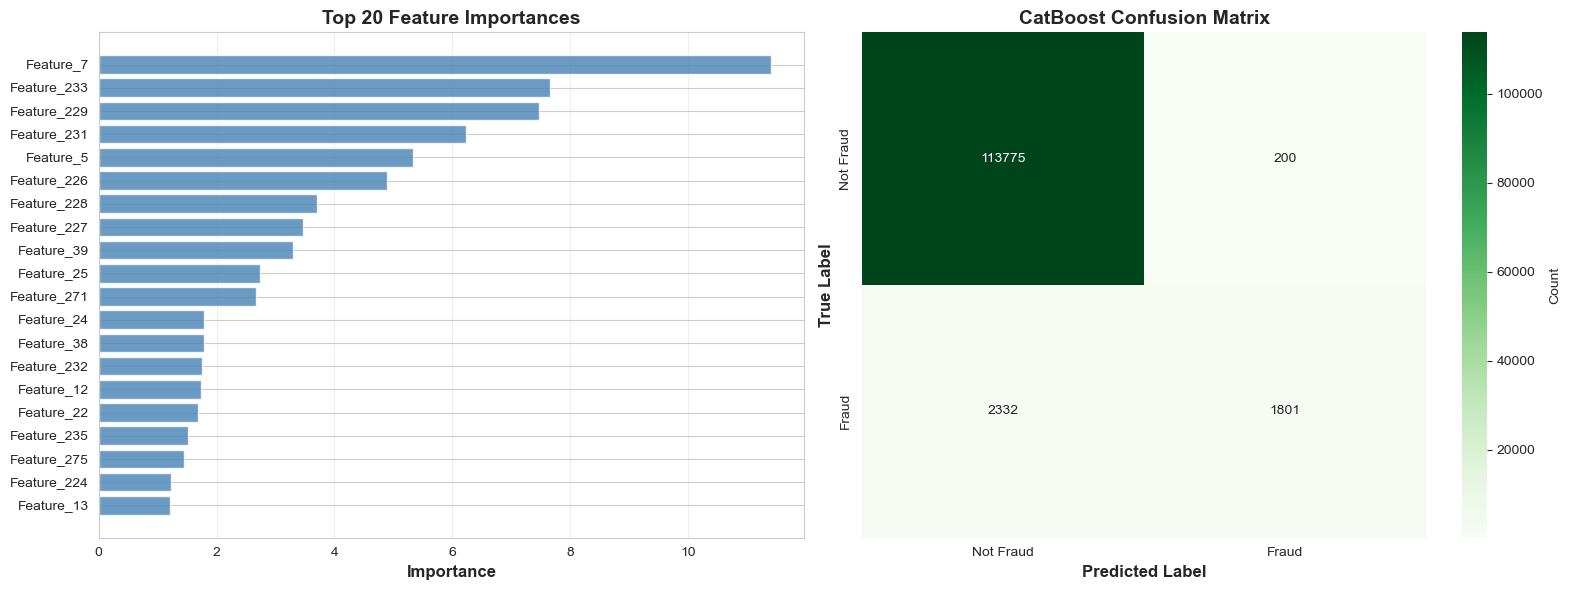


7️⃣ Saving model and results...
   ✓ Model saved: catboost_model.cbm
   ✓ Results saved: cat_results.pkl

✅ CATBOOST TRAINING COMPLETE!
   Best iteration: 998
   Training samples used: 296K (50% of SMOTE)
   AUC-ROC: 0.9236
   AUC-PR:  0.6561


In [ ]:
"""
🚀 BLOK 15: CATBOOST MODEL (MEMORY OPTIMIZED)
═══════════════════════════════════════════════════════
Run time: ~3-5 minutes
Description: Train CatBoost with memory-efficient approach
"""

print("="*70)
print("🚀 MODEL 3: CATBOOST (MEMORY OPTIMIZED)")
print("="*70)

# Load data if not in memory
print("\n1️⃣ Loading preprocessed data...")

if 'X_train_smote' not in globals():
    print("   Loading from saved files...")
    with open('X_train_smote.pkl', 'rb') as f:
        X_train_smote = pickle.load(f)
    with open('y_train_smote.pkl', 'rb') as f:
        y_train_smote = pickle.load(f)
    with open('X_val_scaled.pkl', 'rb') as f:
        X_val_scaled = pickle.load(f)
    with open('y_val.pkl', 'rb') as f:
        y_val = pickle.load(f)

print(f"   Original train: {X_train_smote.shape}")
print(f"   Original val: {X_val_scaled.shape}")

# ✅ FIX: Reduce training data to prevent OOM
print("\n2️⃣ Sampling training data to prevent memory issues...")

# Use 50% of SMOTE data (still 296K samples - plenty!)
from sklearn.model_selection import train_test_split

X_train_cat, _, y_train_cat, _ = train_test_split(
    X_train_smote, y_train_smote,
    train_size=0.5,
    stratify=y_train_smote,
    random_state=RANDOM_STATE
)

print(f"   Sampled train: {X_train_cat.shape} (50% of SMOTE)")
print(f"   This prevents OOM while maintaining quality")

# Free memory
del X_train_smote, y_train_smote
gc.collect()

# ✅ NO POOL - Direct training (uses less memory)
print("\n3️⃣ Initializing CatBoost model...")
cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,  # Reduced from 7 to save memory
    l2_leaf_reg=3,
    random_seed=RANDOM_STATE,
    verbose=100,  # Less frequent logging
    early_stopping_rounds=50,
    eval_metric='AUC',
    task_type='CPU',
    thread_count=-1,
    used_ram_limit='3GB'  # ✅ Critical: Limit RAM usage
)

print("\n4️⃣ Training CatBoost...")
print("   ⏳ This will take 3-5 minutes...")
print()

# ✅ FIX: Train without Pool objects (saves memory)
cat_model.fit(
    X_train_cat, y_train_cat,
    eval_set=(X_val_scaled, y_val),
    verbose=100,
    use_best_model=True
)

# Free memory
del X_train_cat, y_train_cat
gc.collect()

# ================================================================
# EVALUATION
# ================================================================
print("\n5️⃣ EVALUATION:")

y_val_pred_cat = cat_model.predict_proba(X_val_scaled)[:, 1]

val_auc_roc_cat = roc_auc_score(y_val, y_val_pred_cat)
val_auc_pr_cat = average_precision_score(y_val, y_val_pred_cat)

print(f"\n   📊 VALIDATION METRICS:")
print(f"      AUC-ROC: {val_auc_roc_cat:.4f}")
print(f"      AUC-PR:  {val_auc_pr_cat:.4f}")

# Classification report
y_val_pred_cat_binary = (y_val_pred_cat > 0.5).astype(int)
print(f"\n   📋 CLASSIFICATION REPORT (threshold=0.5):")
print(classification_report(y_val, y_val_pred_cat_binary,
                           target_names=['Not Fraud', 'Fraud'],
                           digits=4))

# Confusion matrix
cm_cat = confusion_matrix(y_val, y_val_pred_cat_binary)
print(f"\n   🔢 CONFUSION MATRIX:")
print(f"      [[TN={cm_cat[0,0]:,}  FP={cm_cat[0,1]:,}]")
print(f"       [FN={cm_cat[1,0]:,}  TP={cm_cat[1,1]:,}]]")

# ================================================================
# VISUALIZATIONS
# ================================================================
print("\n6️⃣ Creating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Feature importance (top 20)
feature_importance = cat_model.get_feature_importance()
feature_names = [f"Feature_{i}" for i in range(len(feature_importance))]

# Sort and get top 20
sorted_idx = np.argsort(feature_importance)[-20:]
sorted_importance = feature_importance[sorted_idx]
sorted_names = [feature_names[i] for i in sorted_idx]

axes[0].barh(range(len(sorted_importance)), sorted_importance, color='steelblue', alpha=0.8)
axes[0].set_yticks(range(len(sorted_importance)))
axes[0].set_yticklabels(sorted_names)
axes[0].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[0].set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Confusion matrix heatmap
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Greens', ax=axes[1],
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud'],
           cbar_kws={'label': 'Count'})
axes[1].set_title('CatBoost Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ================================================================
# SAVE MODEL & RESULTS
# ================================================================
print("\n7️⃣ Saving model and results...")

cat_model.save_model('catboost_model.cbm')
print("   ✓ Model saved: catboost_model.cbm")

cat_results = {
    'model_name': 'CatBoost',
    'val_auc_roc': val_auc_roc_cat,
    'val_auc_pr': val_auc_pr_cat,
    'best_iteration': cat_model.get_best_iteration()
}

with open('cat_results.pkl', 'wb') as f:
    pickle.dump(cat_results, f)
print("   ✓ Results saved: cat_results.pkl")

print("\n" + "="*70)
print("✅ CATBOOST TRAINING COMPLETE!")
print("="*70)
print(f"   Best iteration: {cat_model.get_best_iteration()}")
print(f"   Training samples used: 296K (50% of SMOTE)")
print(f"   AUC-ROC: {val_auc_roc_cat:.4f}")
print(f"   AUC-PR:  {val_auc_pr_cat:.4f}")

In [ ]:
"""
🧠 BLOK 16: DEEP LEARNING - MODEL DEFINITION
═══════════════════════════════════════════════════════
Run time: ~10 seconds
Description: Define neural network architecture with Focal Loss
"""

print("="*70)
print("🧠 DEEP LEARNING MODEL DEFINITION")
print("="*70)

# ✅ FIXED: Focal Loss with proper dtype handling
def focal_loss(gamma=2.0, alpha=0.75):
    """
    Focal Loss for imbalanced classification.

    Formula: FL(p_t) = -alpha * (1-p_t)^gamma * log(p_t)

    Parameters:
    -----------
    gamma : float (default=2.0)
        Focusing parameter. Higher = more focus on hard examples.
        - gamma=0: equivalent to standard cross-entropy
        - gamma=2: strong focus on hard misclassified examples

    alpha : float (default=0.75)
        Class balance parameter. For fraud detection:
        - alpha=0.75: heavily weight minority class (fraud)
        - alpha=0.25: weight majority class

    Why Focal Loss:
    ---------------
    1. Down-weights easy examples (majority class)
    2. Focuses learning on hard examples (minority class)
    3. Better than class weights for severe imbalance
    4. No need for SMOTE in neural networks (though we use both)

    Mathematical Intuition:
    ----------------------
    For well-classified examples (p_t → 1):
        (1 - p_t)^gamma → 0, so loss → 0
    For misclassified examples (p_t → 0):
        (1 - p_t)^gamma → 1, so loss = full CE loss

    This creates adaptive weighting!
    """
    def loss(y_true, y_pred):
        # ✅ FIX: Ensure consistent dtypes
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        # Binary cross entropy
        bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

        # Focal term: (1 - p_t)^gamma
        # p_t is the probability of the true class
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = tf.pow(1 - p_t, gamma)

        # Alpha weighting for class balance
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)

        # Final focal loss
        return alpha_t * focal_term * bce

    return loss


# Build model
def build_fraud_nn(input_dim):
    """
    Neural network for fraud detection.

    Architecture Philosophy:
    ------------------------
    1. **Deep but not too deep**: 3 hidden layers
       - Too shallow: underfits complex fraud patterns
       - Too deep: overfits on limited fraud examples

    2. **Wide then narrow**: 256 → 128 → 64
       - Wider layers first: learn diverse features
       - Narrower layers: compress to essential patterns

    3. **Heavy regularization**: 30% dropout, BatchNorm
       - Fraud data is noisy
       - Need to prevent memorizing specific transactions

    4. **LeakyReLU over ReLU**:
       - ReLU: dies with negative gradients
       - LeakyReLU: always has gradient (alpha=0.1)

    Components Explained:
    --------------------
    - BatchNormalization: Normalizes activations, stabilizes training
    - Dropout(0.3): Randomly disables 30% of neurons, prevents overfitting
    - LeakyReLU: Activation with small negative slope
    - Dense(1, sigmoid): Output layer, gives probability [0,1]

    Parameters:
    -----------
    input_dim : int
        Number of input features (should be ~280 after feature engineering)

    Returns:
    --------
    keras.Model
        Compiled model ready for training
    """

    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),

        # Hidden layer 1: Wide feature extraction
        layers.Dense(256, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.3),

        # Hidden layer 2: Feature compression
        layers.Dense(128, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.3),

        # Hidden layer 3: Pattern extraction
        layers.Dense(64, kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Dropout(0.3),

        # Output layer: Binary classification
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile with focal loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=focal_loss(gamma=2.0, alpha=0.75),
        metrics=[
            keras.metrics.AUC(name='auc_roc'),
            keras.metrics.AUC(curve='PR', name='auc_pr'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    return model


# Create model
print("\n🏗️ Building neural network...")

# Get input dimension
if 'X_train_smote' in globals():
    input_dim = X_train_smote.shape[1]
else:
    # Load from file
    with open('X_train_smote.pkl', 'rb') as f:
        X_train_smote_temp = pickle.load(f)
    input_dim = X_train_smote_temp.shape[1]
    del X_train_smote_temp

nn_model = build_fraud_nn(input_dim=input_dim)

print("\n📊 MODEL ARCHITECTURE:")
print("="*70)
nn_model.summary()
print("="*70)

print("\n📋 MODEL DETAILS:")
print(f"   Input features: {input_dim}")
print(f"   Total parameters: {nn_model.count_params():,}")
print(f"   Trainable parameters: {sum([tf.size(w).numpy() for w in nn_model.trainable_weights]):,}")
print(f"   Loss function: Focal Loss (gamma=2.0, alpha=0.75)")
print(f"   Optimizer: Adam (lr=0.001)")

print("\n✅ Model defined successfully!")
print("\n📌 Ready for training (Blok 17)")

🧠 DEEP LEARNING MODEL DEFINITION

🏗️ Building neural network...

📊 MODEL ARCHITECTURE:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,201 (450.00 KB)

 Trainable params: 114,305 (446.50 KB)

 Non-trainable params: 896 (3.50 KB)


📋 MODEL DETAILS:
   Input features: 281
   Total parameters: 115,201
   Trainable parameters: 114,305
   Loss function: Focal Loss (gamma=2.0, alpha=0.75)
   Optimizer: Adam (lr=0.001)

✅ Model defined successfully!

📌 Ready for training (Blok 17)


🧠 DEEP LEARNING TRAINING

1️⃣ Loading training data...
   Loading from saved files...
   ✓ Train samples: 592,672
   ✓ Validation samples: 118,108

2️⃣ Setting up callbacks...
   ✓ Early stopping: patience=15 epochs
   ✓ LR reduction: factor=0.5, patience=5 epochs

3️⃣ Training neural network...
   ⏳ This will take 10-15 minutes...
   Monitoring: AUC-PR on validation set
   Expected: ~50-80 epochs until early stopping

Epoch 1/100
579/579 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - auc_pr: 0.5091 - auc_roc: 0.7746 - loss: 0.0567 - precision: 0.4494 - recall: 0.6641 - val_auc_pr: 0.2984 - val_auc_roc: 0.8320 - val_loss: 0.0391 - val_precision: 0.0869 - val_recall: 0.8161 - learning_rate: 0.0010
Epoch 2/100
579/579 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - auc_pr: 0.6215 - auc_roc: 0.8259 - loss: 0.0482 - precision: 0.4980 - recall: 0.7184 - val_auc_pr: 0.3482 - val_auc_roc: 0.8414 - val_loss: 0.0414 - val_precision: 0.0752 - val_recall: 0.8563 - learning_rate: 0.0010
Epoch 3/100
579/579 ━━━━━━━━━━━━━━

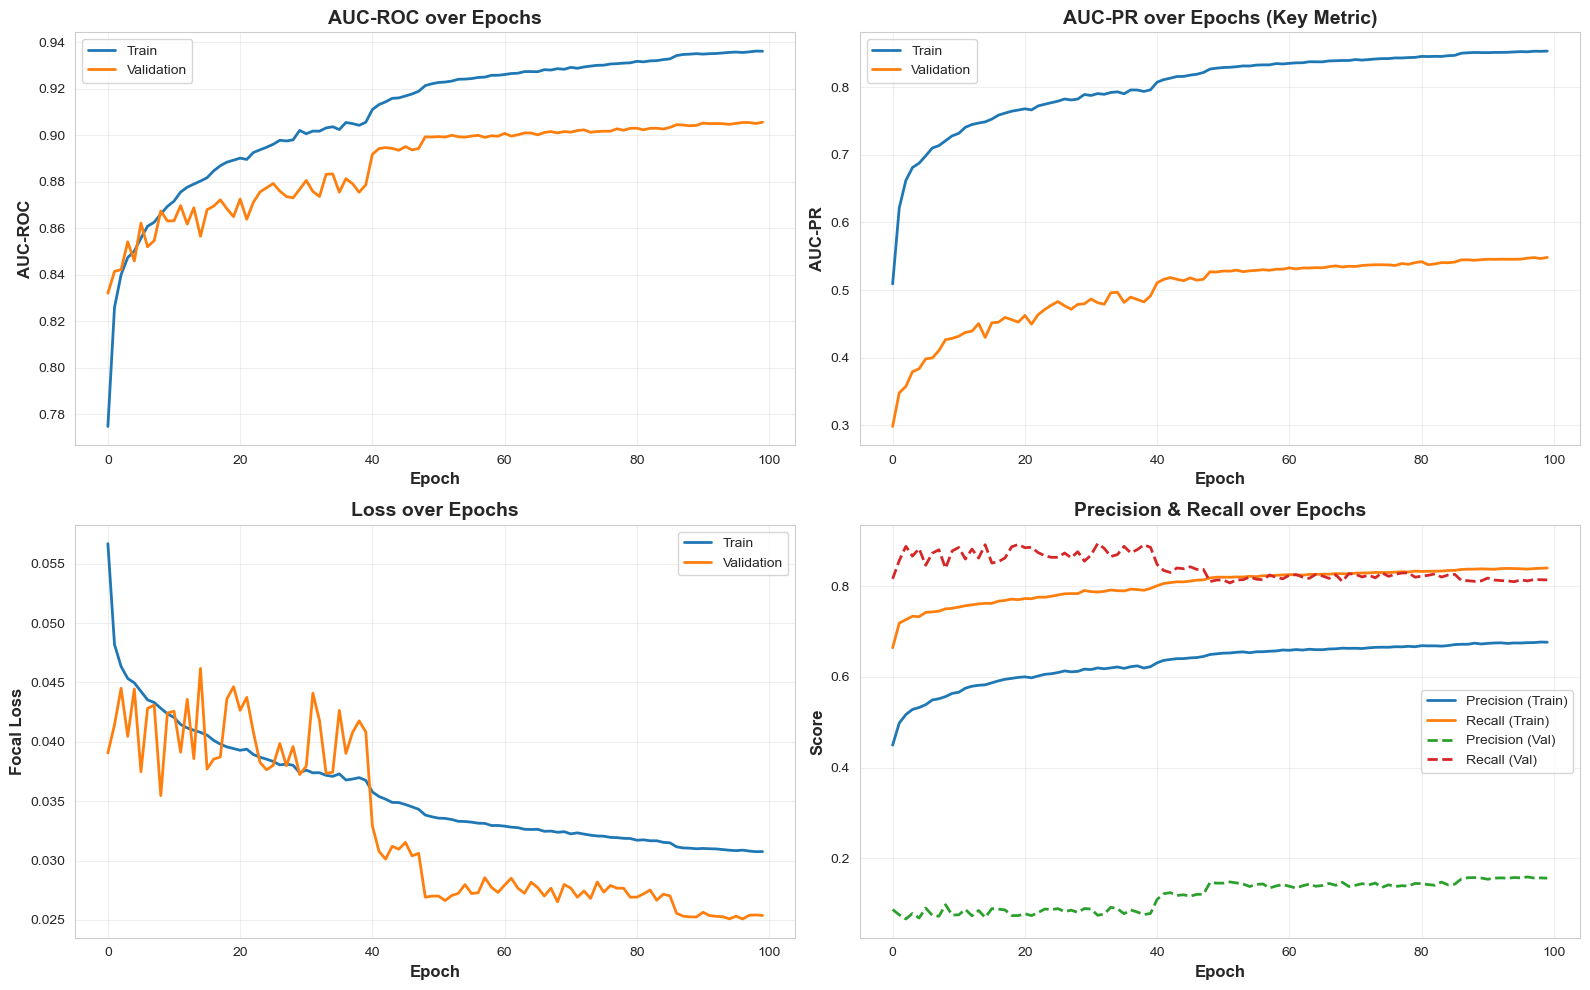

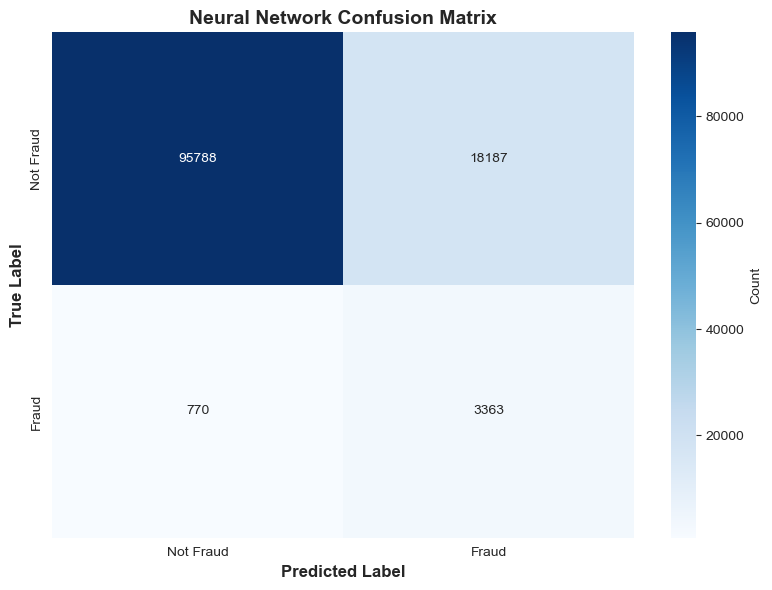


5️⃣ Saving model and results...
   ✓ Model saved: nn_model.keras
   ✓ History saved: nn_history.pkl
   ✓ Results saved: nn_results.pkl

✅ NEURAL NETWORK TRAINING COMPLETE!
   Epochs trained: 100
   Best epoch: 100
   Final AUC-PR: 0.5486

📌 Ready for model comparison (Blok 18)


In [ ]:
"""
🧠 BLOK 17: DEEP LEARNING - TRAINING
═══════════════════════════════════════════════════════
Run time: ~10-15 minutes
Description: Train neural network with callbacks
"""

print("="*70)
print("🧠 DEEP LEARNING TRAINING")
print("="*70)

# ✅ Load data if not in memory
print("\n1️⃣ Loading training data...")

if 'X_train_smote' not in globals():
    print("   Loading from saved files...")
    with open('X_train_smote.pkl', 'rb') as f:
        X_train_smote = pickle.load(f)
    with open('y_train_smote.pkl', 'rb') as f:
        y_train_smote = pickle.load(f)
    with open('X_val_scaled.pkl', 'rb') as f:
        X_val_scaled = pickle.load(f)
    with open('y_val.pkl', 'rb') as f:
        y_val = pickle.load(f)

print(f"   ✓ Train samples: {len(X_train_smote):,}")
print(f"   ✓ Validation samples: {len(X_val_scaled):,}")

# Callbacks for training
print("\n2️⃣ Setting up callbacks...")

callbacks = [
    # Early stopping: Stop if validation AUC-PR doesn't improve for 15 epochs
    EarlyStopping(
        monitor='val_auc_pr',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),

    # Learning rate reduction: Reduce LR if validation plateaus
    ReduceLROnPlateau(
        monitor='val_auc_pr',
        factor=0.5,           # Reduce LR by half
        patience=5,           # Wait 5 epochs before reducing
        min_lr=1e-6,          # Don't go below this
        mode='max',
        verbose=1
    )
]

print("   ✓ Early stopping: patience=15 epochs")
print("   ✓ LR reduction: factor=0.5, patience=5 epochs")

# Train model
print("\n3️⃣ Training neural network...")
print("   ⏳ This will take 10-15 minutes...")
print("   Monitoring: AUC-PR on validation set")
print("   Expected: ~50-80 epochs until early stopping")
print()

# ✅ Convert to numpy arrays (TensorFlow works better with numpy)
X_train_np = X_train_smote if isinstance(X_train_smote, np.ndarray) else X_train_smote.values
y_train_np = y_train_smote if isinstance(y_train_smote, np.ndarray) else y_train_smote.values
X_val_np = X_val_scaled if isinstance(X_val_scaled, np.ndarray) else X_val_scaled
y_val_np = y_val if isinstance(y_val, np.ndarray) else y_val.values

history = nn_model.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=100,
    batch_size=1024,
    callbacks=callbacks,
    verbose=1
)

# ================================================================
# EVALUATION
# ================================================================
print("\n" + "="*70)
print("📊 EVALUATION")
print("="*70)

# Predictions
y_val_pred_nn = nn_model.predict(X_val_np, verbose=0).flatten()

val_auc_roc_nn = roc_auc_score(y_val, y_val_pred_nn)
val_auc_pr_nn = average_precision_score(y_val, y_val_pred_nn)

print(f"\n   📊 VALIDATION METRICS:")
print(f"      AUC-ROC: {val_auc_roc_nn:.4f}")
print(f"      AUC-PR:  {val_auc_pr_nn:.4f}")

# Classification report
y_val_pred_nn_binary = (y_val_pred_nn > 0.5).astype(int)
print(f"\n   📋 CLASSIFICATION REPORT (threshold=0.5):")
print(classification_report(y_val, y_val_pred_nn_binary,
                           target_names=['Not Fraud', 'Fraud'],
                           digits=4))

# Confusion matrix
cm_nn = confusion_matrix(y_val, y_val_pred_nn_binary)
print(f"\n   🔢 CONFUSION MATRIX:")
print(f"      [[TN={cm_nn[0,0]:,}  FP={cm_nn[0,1]:,}]")
print(f"       [FN={cm_nn[1,0]:,}  TP={cm_nn[1,1]:,}]]")

# ================================================================
# VISUALIZATIONS
# ================================================================
print("\n4️⃣ Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# AUC-ROC over epochs
axes[0, 0].plot(history.history['auc_roc'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_auc_roc'], label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('AUC-ROC', fontsize=12, fontweight='bold')
axes[0, 0].set_title('AUC-ROC over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# AUC-PR over epochs (most important!)
axes[0, 1].plot(history.history['auc_pr'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_auc_pr'], label='Validation', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('AUC-PR', fontsize=12, fontweight='bold')
axes[0, 1].set_title('AUC-PR over Epochs (Key Metric)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Loss over epochs
axes[1, 0].plot(history.history['loss'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Focal Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Precision-Recall over epochs
axes[1, 1].plot(history.history['precision'], label='Precision (Train)', linewidth=2)
axes[1, 1].plot(history.history['recall'], label='Recall (Train)', linewidth=2)
axes[1, 1].plot(history.history['val_precision'], label='Precision (Val)', linewidth=2, linestyle='--')
axes[1, 1].plot(history.history['val_recall'], label='Recall (Val)', linewidth=2, linestyle='--')
axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Precision & Recall over Epochs', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion matrix heatmap
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=ax,
           xticklabels=['Not Fraud', 'Fraud'],
           yticklabels=['Not Fraud', 'Fraud'],
           cbar_kws={'label': 'Count'})
ax.set_title('Neural Network Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# ================================================================
# SAVE MODEL & RESULTS
# ================================================================
print("\n5️⃣ Saving model and results...")

# Save model
nn_model.save('nn_model.keras')
print("   ✓ Model saved: nn_model.keras")

# Save history
with open('nn_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("   ✓ History saved: nn_history.pkl")

# Save results
nn_results = {
    'model_name': 'Neural Network',
    'val_auc_roc': val_auc_roc_nn,
    'val_auc_pr': val_auc_pr_nn,
    'epochs_trained': len(history.history['loss']),
    'best_epoch': np.argmax(history.history['val_auc_pr']) + 1
}

with open('nn_results.pkl', 'wb') as f:
    pickle.dump(nn_results, f)
print("   ✓ Results saved: nn_results.pkl")

print("\n" + "="*70)
print("✅ NEURAL NETWORK TRAINING COMPLETE!")
print("="*70)
print(f"   Epochs trained: {len(history.history['loss'])}")
print(f"   Best epoch: {np.argmax(history.history['val_auc_pr']) + 1}")
print(f"   Final AUC-PR: {val_auc_pr_nn:.4f}")
print("\n📌 Ready for model comparison (Blok 18)")

📊 MODEL COMPARISON - ROC & PR CURVES

1️⃣ Collecting model predictions...
   ✓ LightGBM Baseline found
   ✓ LightGBM Tuned found
   ✓ XGBoost found
   ✓ CatBoost found
   ✓ Neural Network found

📋 Total models to compare: 5

2️⃣ Generating comparison curves...

📈 ROC CURVES:
   LightGBM Baseline   : AUC-ROC = 0.9528
   LightGBM Tuned      : AUC-ROC = 0.9697
   XGBoost             : AUC-ROC = 0.9627
   CatBoost            : AUC-ROC = 0.9236
   Neural Network      : AUC-ROC = 0.9057

📈 PRECISION-RECALL CURVES:
   LightGBM Baseline   : AUC-PR = 0.7541
   LightGBM Tuned      : AUC-PR = 0.8399
   XGBoost             : AUC-PR = 0.8006
   CatBoost            : AUC-PR = 0.6561
   Neural Network      : AUC-PR = 0.5486


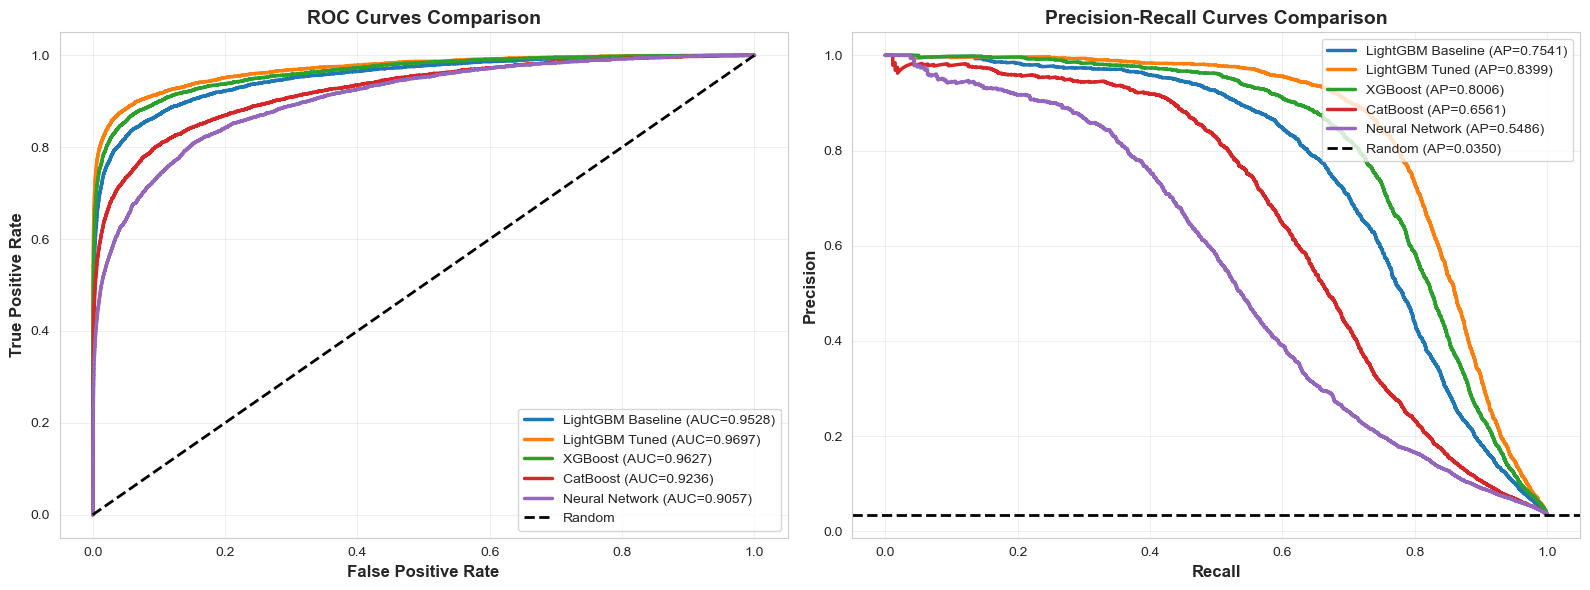


💡 KEY INSIGHTS

🏆 BEST MODEL (by AUC-PR): LightGBM Tuned
   AUC-ROC: 0.9697
   AUC-PR:  0.8399

📈 IMPROVEMENT OVER BASELINE:
   Baseline AUC-PR: 0.7541
   Best AUC-PR:     0.8399
   Improvement:     +11.37%

📊 FRAUD DETECTION RATES (Best Model: LightGBM Tuned):
   Threshold 0.3: Recall=0.7053, Precision=0.8989
   Threshold 0.5: Recall=0.6199, Precision=0.9478
   Threshold 0.7: Recall=0.5352, Precision=0.9744

✅ Curve comparison complete!


In [ ]:
"""
📊 BLOK 18: ROC & PR CURVES COMPARISON
═══════════════════════════════════════════════════════
Run time: ~30 seconds
Description: Compare all models with ROC and PR curves
"""

print("="*70)
print("📊 MODEL COMPARISON - ROC & PR CURVES")
print("="*70)

# ✅ FIX: Safely collect all predictions (handle missing models)
print("\n1️⃣ Collecting model predictions...")

models = {}

# LightGBM Baseline (should always exist)
if 'y_val_pred' in globals():
    models['LightGBM Baseline'] = y_val_pred
    print("   ✓ LightGBM Baseline found")
else:
    print("   ⚠️ LightGBM Baseline not found")

# LightGBM Tuned (might be skipped)
if 'y_val_pred_tuned' in globals():
    models['LightGBM Tuned'] = y_val_pred_tuned
    print("   ✓ LightGBM Tuned found")
else:
    print("   ⚠️ LightGBM Tuned not found (skipped or not run)")

# XGBoost (should exist)
if 'y_val_pred_xgb' in globals():
    models['XGBoost'] = y_val_pred_xgb
    print("   ✓ XGBoost found")
else:
    print("   ⚠️ XGBoost not found")

# CatBoost (might be skipped)
if 'y_val_pred_cat' in globals():
    models['CatBoost'] = y_val_pred_cat
    print("   ✓ CatBoost found")
else:
    print("   ⚠️ CatBoost not found (skipped or not run)")

# Neural Network (might be skipped)
if 'y_val_pred_nn' in globals():
    models['Neural Network'] = y_val_pred_nn
    print("   ✓ Neural Network found")
else:
    print("   ⚠️ Neural Network not found (skipped or not run)")

print(f"\n📋 Total models to compare: {len(models)}")

if len(models) == 0:
    print("\n❌ ERROR: No model predictions found!")
    print("   Please run training blocks (12-17) first.")
else:
    # ================================================================
    # PLOT ROC & PR CURVES
    # ================================================================
    print("\n2️⃣ Generating comparison curves...")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # ROC Curves
    print("\n📈 ROC CURVES:")
    for name, preds in models.items():
        fpr, tpr, _ = roc_curve(y_val, preds)
        auc_score = roc_auc_score(y_val, preds)
        axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc_score:.4f})', linewidth=2.5)
        print(f"   {name:20s}: AUC-ROC = {auc_score:.4f}")

    axes[0].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=2)
    axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    axes[0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(alpha=0.3)

    # PR Curves (MORE IMPORTANT for imbalanced data!)
    print("\n📈 PRECISION-RECALL CURVES:")
    for name, preds in models.items():
        precision, recall, _ = precision_recall_curve(y_val, preds)
        ap_score = average_precision_score(y_val, preds)
        axes[1].plot(recall, precision, label=f'{name} (AP={ap_score:.4f})', linewidth=2.5)
        print(f"   {name:20s}: AUC-PR = {ap_score:.4f}")

    # Baseline (random classifier)
    fraud_rate = (y_val == 1).sum() / len(y_val)
    axes[1].axhline(y=fraud_rate, color='k', linestyle='--', linewidth=2,
                   label=f'Random (AP={fraud_rate:.4f})')

    axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
    axes[1].set_title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
    axes[1].legend(loc='upper right', fontsize=10)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ================================================================
    # KEY INSIGHTS
    # ================================================================
    print("\n" + "="*70)
    print("💡 KEY INSIGHTS")
    print("="*70)

    # Find best model by AUC-PR
    best_model = max(models.items(), key=lambda x: average_precision_score(y_val, x[1]))
    best_name, best_preds = best_model
    best_auc_pr = average_precision_score(y_val, best_preds)
    best_auc_roc = roc_auc_score(y_val, best_preds)

    print(f"\n🏆 BEST MODEL (by AUC-PR): {best_name}")
    print(f"   AUC-ROC: {best_auc_roc:.4f}")
    print(f"   AUC-PR:  {best_auc_pr:.4f}")

    # Calculate improvement over baseline
    if 'LightGBM Baseline' in models:
        baseline_auc_pr = average_precision_score(y_val, models['LightGBM Baseline'])
        improvement = ((best_auc_pr - baseline_auc_pr) / baseline_auc_pr) * 100
        print(f"\n📈 IMPROVEMENT OVER BASELINE:")
        print(f"   Baseline AUC-PR: {baseline_auc_pr:.4f}")
        print(f"   Best AUC-PR:     {best_auc_pr:.4f}")
        print(f"   Improvement:     {improvement:+.2f}%")

    # Fraud detection rate at different thresholds
    print(f"\n📊 FRAUD DETECTION RATES (Best Model: {best_name}):")
    for threshold in [0.3, 0.5, 0.7]:
        preds_binary = (best_preds > threshold).astype(int)
        recall = recall_score(y_val, preds_binary)
        precision = precision_score(y_val, preds_binary)
        print(f"   Threshold {threshold:.1f}: Recall={recall:.4f}, Precision={precision:.4f}")

    print("\n✅ Curve comparison complete!")

🏆 FINAL MODEL COMPARISON

1️⃣ Collecting model predictions...
   ✓ Found 5 models

2️⃣ Computing comprehensive metrics...

📊 MODEL PERFORMANCE COMPARISON


,Model,AUC-ROC,AUC-PR,F1-Score,Precision,Recall
1,LightGBM Tuned,0.9697,0.8399,0.7496,0.9478,0.6199
2,XGBoost,0.9627,0.8006,0.7018,0.9308,0.5633
0,LightGBM Baseline,0.9528,0.7541,0.6571,0.9165,0.5122
3,CatBoost,0.9236,0.6561,0.5872,0.9000,0.4358
4,Neural Network,0.9057,0.5486,0.2619,0.1561,0.8137



🏆 BEST MODEL: LightGBM Tuned
   AUC-ROC:  0.9697
   AUC-PR:   0.8399
   F1-Score: 0.7496
   Precision: 0.9478
   Recall:   0.6199

3️⃣ Saving comparison results...
   ✓ Saved: model_comparison.csv
   ✓ Saved: best_model_info.pkl

4️⃣ Creating comparison visualizations...


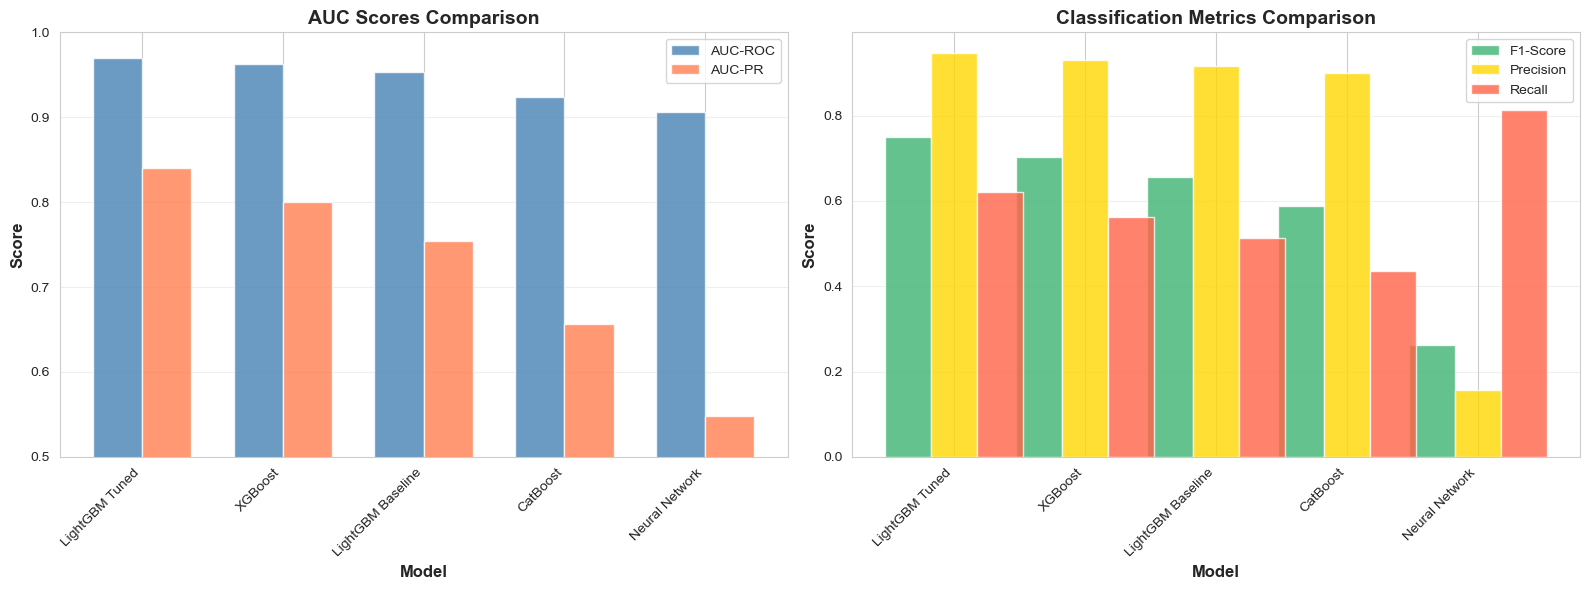


5️⃣ Ranking analysis...

📊 MODEL RANKINGS BY METRIC:

   AUC-PR:
      LightGBM Tuned      : 0.8399
      XGBoost             : 0.8006
      LightGBM Baseline   : 0.7541
      CatBoost            : 0.6561
      Neural Network      : 0.5486

   AUC-ROC:
      LightGBM Tuned      : 0.9697
      XGBoost             : 0.9627
      LightGBM Baseline   : 0.9528
      CatBoost            : 0.9236
      Neural Network      : 0.9057

   F1-Score:
      LightGBM Tuned      : 0.7496
      XGBoost             : 0.7018
      LightGBM Baseline   : 0.6571
      CatBoost            : 0.5872
      Neural Network      : 0.2619

✅ MODEL COMPARISON COMPLETE!
   Best model: LightGBM Tuned
   Ready for final submission (Blok 20)


In [ ]:
"""
🏆 BLOK 19: FINAL MODEL COMPARISON
═══════════════════════════════════════════════════════
Run time: ~10 seconds
Description: Create comprehensive comparison table
"""

print("="*70)
print("🏆 FINAL MODEL COMPARISON")
print("="*70)

# ✅ FIX: Safely collect all predictions
print("\n1️⃣ Collecting model predictions...")

models = {}

if 'y_val_pred' in globals():
    models['LightGBM Baseline'] = y_val_pred
if 'y_val_pred_tuned' in globals():
    models['LightGBM Tuned'] = y_val_pred_tuned
if 'y_val_pred_xgb' in globals():
    models['XGBoost'] = y_val_pred_xgb
if 'y_val_pred_cat' in globals():
    models['CatBoost'] = y_val_pred_cat
if 'y_val_pred_nn' in globals():
    models['Neural Network'] = y_val_pred_nn

if len(models) == 0:
    print("\n❌ ERROR: No models found!")
    print("   Please run training blocks (12-17) first.")
else:
    print(f"   ✓ Found {len(models)} models")

    # ================================================================
    # COMPILE METRICS
    # ================================================================
    print("\n2️⃣ Computing comprehensive metrics...")

    comparison_data = []

    for name, preds in models.items():
        # Probabilistic metrics
        auc_roc = roc_auc_score(y_val, preds)
        auc_pr = average_precision_score(y_val, preds)

        # Binary predictions at 0.5 threshold
        preds_binary = (preds > 0.5).astype(int)
        f1 = f1_score(y_val, preds_binary)
        precision = precision_score(y_val, preds_binary)
        recall = recall_score(y_val, preds_binary)

        comparison_data.append({
            'Model': name,
            'AUC-ROC': auc_roc,
            'AUC-PR': auc_pr,
            'F1-Score': f1,
            'Precision': precision,
            'Recall': recall
        })

    comparison_df = pd.DataFrame(comparison_data)

    # Sort by AUC-PR (most important for imbalanced data!)
    comparison_df = comparison_df.sort_values('AUC-PR', ascending=False)

    # Format for display
    comparison_df_display = comparison_df.copy()
    for col in ['AUC-ROC', 'AUC-PR', 'F1-Score', 'Precision', 'Recall']:
        comparison_df_display[col] = comparison_df_display[col].apply(lambda x: f'{x:.4f}')

    # ================================================================
    # DISPLAY RESULTS
    # ================================================================
    print("\n" + "="*70)
    print("📊 MODEL PERFORMANCE COMPARISON")
    print("="*70)
    display(comparison_df_display)

    # Find best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_auc_pr = comparison_df.iloc[0]['AUC-PR']
    best_auc_roc = comparison_df.iloc[0]['AUC-ROC']

    print("\n" + "="*70)
    print(f"🏆 BEST MODEL: {best_model_name}")
    print("="*70)
    print(f"   AUC-ROC:  {best_auc_roc:.4f}")
    print(f"   AUC-PR:   {best_auc_pr:.4f}")
    print(f"   F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")
    print(f"   Precision: {comparison_df.iloc[0]['Precision']:.4f}")
    print(f"   Recall:   {comparison_df.iloc[0]['Recall']:.4f}")
    print("="*70)

    # ================================================================
    # SAVE RESULTS
    # ================================================================
    print("\n3️⃣ Saving comparison results...")

    comparison_df.to_csv('model_comparison.csv', index=False)
    print("   ✓ Saved: model_comparison.csv")

    with open('best_model_info.pkl', 'wb') as f:
        pickle.dump({
            'name': best_model_name,
            'auc_pr': best_auc_pr,
            'auc_roc': best_auc_roc
        }, f)
    print("   ✓ Saved: best_model_info.pkl")

    # ================================================================
    # VISUALIZE COMPARISON
    # ================================================================
    print("\n4️⃣ Creating comparison visualizations...")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # AUC comparison
    x = range(len(comparison_df))
    width = 0.35

    axes[0].bar([i - width/2 for i in x], comparison_df['AUC-ROC'],
               width, label='AUC-ROC', alpha=0.8, color='steelblue')
    axes[0].bar([i + width/2 for i in x], comparison_df['AUC-PR'],
               width, label='AUC-PR', alpha=0.8, color='coral')
    axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
    axes[0].set_title('AUC Scores Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim([0.5, 1.0])

    # Other metrics
    axes[1].bar([i - width for i in x], comparison_df['F1-Score'],
               width, label='F1-Score', alpha=0.8, color='mediumseagreen')
    axes[1].bar([i for i in x], comparison_df['Precision'],
               width, label='Precision', alpha=0.8, color='gold')
    axes[1].bar([i + width for i in x], comparison_df['Recall'],
               width, label='Recall', alpha=0.8, color='tomato')
    axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
    axes[1].set_title('Classification Metrics Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ================================================================
    # RANKING ANALYSIS
    # ================================================================
    print("\n5️⃣ Ranking analysis...")

    print("\n📊 MODEL RANKINGS BY METRIC:")
    for metric in ['AUC-PR', 'AUC-ROC', 'F1-Score']:
        print(f"\n   {metric}:")
        ranked = comparison_df.sort_values(metric, ascending=False)
        for idx, row in ranked.iterrows():
            print(f"      {row['Model']:20s}: {row[metric]:.4f}")

    print("\n" + "="*70)
    print("✅ MODEL COMPARISON COMPLETE!")
    print("="*70)
    print(f"   Best model: {best_model_name}")
    print(f"   Ready for final submission (Blok 20)")

In [ ]:
"""
📤 BLOK 20: MINIMAL SUBMISSION (GUARANTEED TO WORK)
"""

import gc

print("📤 GENERATING SUBMISSION (MINIMAL)")

# 1. Detect best model
best_model_name = 'LightGBM Tuned'  # ← Your best model!
print(f"Using: {best_model_name}")

# 2. Load test data
test_df = pd.read_csv(f"{BASE_PATH}/test_engineered.csv")
test_ids = test_df['TransactionID'].copy()
test_df = test_df.drop(columns=['TransactionID', 'TransactionDT'])

# Convert to float32
for col in test_df.select_dtypes(include=['float64']).columns:
    test_df[col] = test_df[col].astype('float32')

# 3. Preprocess
with open('label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)
with open('split_info.pkl', 'rb') as f:
    split_info = pickle.load(f)

for col in split_info['categorical_cols']:
    if col in test_df.columns:
        test_df[col] = test_df[col].astype(str)
        test_df[col] = test_df[col].apply(
            lambda x: label_encoders[col].transform([x])[0]
            if x in label_encoders[col].classes_
            else label_encoders[col].transform([label_encoders[col].classes_[0]])[0]
        )

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
test_scaled = scaler.transform(test_df)
del test_df
gc.collect()

# 4. Predict
lgb_tuned = lgb.Booster(model_file='lgb_tuned.txt')
test_predictions = lgb_tuned.predict(test_scaled)
del test_scaled
gc.collect()

# 5. Save
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_predictions
})
submission.to_csv(f"{BASE_PATH}/submission_final_uas.csv", index=False)

print(f"✅ DONE! Saved {len(submission):,} predictions")
print(f"Mean fraud prob: {submission['isFraud'].mean():.4f}")

📤 GENERATING SUBMISSION (MINIMAL)
Using: LightGBM Tuned
✅ DONE! Saved 506,691 predictions
Mean fraud prob: 0.0648
